In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import cg
from scipy.linalg import solve
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg,bicgstab
from matplotlib.animation import ArtistAnimation
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LightSource

# Постановка задачи

Рассматривается начально-краевая задача, описивающая колебание тонкой кввадратной мембрани:

$\begin{cases}
\dfrac{\partial^2{u}}{\partial{t^2}} = \dfrac{\partial^2{u}}{\partial{x^2}} + \dfrac{\partial^2{u}}{\partial{y^2}} + f & (x,y)\in G, & t\in [0;T] & (1.1) \\
u(x,y,t) = g & (x,y)\in \partial{G} & t\in[0;T] & (1.2) \\
u(x,y,0) = v_1(x,y) & \dfrac{\partial{u}}{\partial{t}}(x,y,0) = v_2 & (x,y)\in G & (1.3)
\end{cases}$

Где $G = [0;1]\times[0;1]$


- Функция $u$ играет роль отклонения мембраны от положения покоя.
- Уравнение $(1.1)$ описывает колебательный процесс
- Краевое условие $(1.2)$ показывает положение краев мембран во времени.
- Начальные условия $(1.3)$ показывают положение и скорость мембран в начальный момент времени.

Необходимо решить задачу $(1.1)-(1.3)$, используя явную и неяную схему метода конечных разностей.

Предоставить результат решения в  виде анимации, демонстрирующей колебание мембран

Предложенные модельные задачи:
1. $\begin{array}& g = 0, & v_1 = 0, & v_2 = 0, & f = e^{-10((x-0.5)^2 + (y-0.5)^2)-t}\end{array}$
2. $\begin{array}& g = 0, & v_1 = x^{10}(1-x)y(1-y), & v_2 = 0, & f = 0\end{array}$
3. $\begin{array}& g = 0, & v_1 = 0, & v_2 = x^{10}(1-x)y(1-y), & f = 0\end{array}$
4. $\begin{array}& g(0,y) = y(1-y), & g(1,y) = 0, & g(x,0) = 0, & g(x,1) = 0, & v_1= (1-x)y(1-y)\cos(5\pi x), & v_2 = 0, & f = 0 \end{array}$
5. $\begin{array}& g = \dfrac{5\sin{t}}{t+1}, & v_1 = 0, &  v_2 = 0, & f = 0 \end{array}$

# План решения задачи:

1. Составление разностнх схем
    - Составление явной схемы
    - Составление неявной схемы
4. Исследование на устойчивость(будет добавлено в будущем)
5. Поиск аналитического решения(будет добавлено в будущем)
6. Реализация подпрограмм
    - Для явной схем
    - Для неявной схем
    - Отрисовка
9. Решение модельнх задач
    - Явной схемой
    - Неявной схемой
12. Поиск аналитического решения для конкретнх задач и оценка погрешности
    - Для явной схем
    - Для неявной схем    

# 1. Составление разностнх схем

## 1.1. Составление явной схемы

Нам необходимо составить разностную схему для задачи $(1.1)-(1.3)$.

Разностную схему будем составлять при помощи аппроксимации производных, в нашем уравнении все производные второго порядка, поэтому достаточно определиться с аппроксимацией производной второго порядка.

Можно использовать двойное взятие центрально-разностной производной с половинным шагом:
$$f'x) = \dfrac{f(x+h/2) - f(x-h/2)}{2\cdot h/2} = \dfrac{f(x+h/2) -f(x-h/2)}{h}$$
$$f''(x) = \dfrac{f'(x+h/2) - f'(x-h/2)}{h} = \dfrac{\dfrac{f(x+h) - f(x)}{h} -\dfrac{f(x) - f(x-h)}{h}}{h} = \dfrac{f(x+h) - 2f(x) + f(x-h)}{h^2}$$

Тогда ДУ $(1.1)$ можно заменить следующей явной разностной схемой:

$\begin{array} & \dfrac{u^{n+1}_{i,j} - 2u^{n}_{i,j} + u^{n-1}_{i,j}}{h^2_t} = \dfrac{u^{n}_{i+1,j} - 2u^{n}_{i,j} + u^{n}_{i-1,j}}{h^2_x} + \dfrac{u^{n}_{i,j+1} - 2u^{n}_{i,j} + u^{n}_{i,j-1}}{h^2_y} + f_{i,j}^n & (2.1)\end{array}$

Договоримся индексами $i,j,n$ обозначать значения сеточной функции от $x,y,t$ соответственно

Однако необходимо также заменить условия $(1.2) - (1.3)$

$(1.2)$ можно заменить следующим образом:

$\begin{array}& u_{0,j,t} = g(0,j,t), & u_{M,j,t} = g(M,j,t), & u_{i,0,t} = g(i,0,t), & u_{i,N,t} = g(i,N,t) & (2.2)\end{array}$

Где $M,N$ - максимально возможные индексы сетки по $1,2$ осям соответственно.

Перед преобразованием условия $(1.3)$ заметим, что данная явная разностная схема позволяет искать численное решение задачи двухшаговым методом:

$$u^{n+1}_{i,j}  = \Big[\dfrac{u^{n}_{i+1,j} - 2u^{n}_{i,j} + u^{n}_{i-1,j}}{h^2_x} + \dfrac{u^{n}_{i,j+1} - 2u^{n}_{i,j} + u^{n}_{i,j-1}}{h^2_y} + f_{i,j}^n\Big]h^2_t + 2u^n_{i,j} - u^{n-1}_{i,j}$$

Однако нам неизвестно значение на втором временном слое: $u^{1}_{i,j}$ его можно получить с помощью разложения по формуле Тейлора:

$$u(x,y,h) = u(x,y,0) + h \dfrac{\partial{u}}{\partial{t}}\Big|_{t=0} + \dfrac{h^2}{2}\dfrac{\partial^2{u}}{\partial{t^2}}\Big|_{t=0}$$

- $\dfrac{\partial^2{u}}{\partial{t^2}}\Big|_{t=0}$ можно получить из дифференциального уравнения
- $\dfrac{\partial{u}}{\partial{t}}\Big|_{t=0} = v_1$  дано в условии $(1.3)$


С этим условием получим:
$\begin{array}& u^{0}_{i,j} = v_{1_{i,j}}, & u^{1}_{i,j} = v_{1_{i,j}} + h_t v_{2_{i,j}} + \dfrac{h^2_t}{2}\Big[\dfrac{u^{0}_{i+1,j} - 2u^{0}_{i,j} + u^{0}_{i-1,j}}{h^2_x} + \dfrac{u^{0}_{i,j+1} - 2u^{0}_{i,j} + u^{0}_{i,j-1}}{h^2_y} + f_{i,j}^0\Big] &(2.3)\end{array}$

Таким образом для задачи $(1.1)-(1.3)$ получили явную разностную схему $(2.1)-(2.3)$

С переходом на новый слой следующего вида:

$$u^{n+1}_{i,j}  = \Big[\dfrac{u^{n}_{i+1,j} - 2u^{n}_{i,j} + u^{n}_{i-1,j}}{h^2_x} + \dfrac{u^{n}_{i,j+1} - 2u^{n}_{i,j} + u^{n}_{i,j-1}}{h^2_y} + f_{i,j}^n\Big]h^2_t + 2u^n_{i,j} - u^{n-1}_{i,j}$$

## 1.2. Составление неявной схемы

 Идея составления неявной схемы похожа на идею составления явной схемы, однако в данном случае для пространнственных производных выражение будем брать как среднее между соседними временными слоями:
 $\begin{array}& \dfrac{u^{n+1}_{i,j} - 2u^{n}_{i,j} + u^{n-1}_{i,j}}{h^2_t} = \dfrac{u^{n+1}_{i+1,j} - 2u^{n+1}_{i,j} + u^{n+1}_{i-1,j}}{2h^2_x} + \dfrac{u^{n-1}_{i+1,j} - 2u^{n-1}_{i,j} + u^{n-1}_{i-1,j}}{2h^2_x} + \dfrac{u^{n+1}_{i,j+1} - 2u^{n+1}_{i,j} + u^{n+1}_{i,j-1}}{2h^2_y} - \dfrac{u^{n-1}_{i,j+1} - 2u^{n-1}_{i,j} + u^{n-1}_{i,j-1}}{2h^2_y} + f_{i,j}^n &(3.1)\end{array}$

 Остальные части останутся прежними:

 $\begin{array}& u_{0,j,t} = g(0,j,t), & u_{M,j,t} = g(M,j,t), & u_{i,0,t} = g(i,0,t), & u_{i,N,t} = g(i,N,t) & (3.2)\end{array}$

 $\begin{array}& u^{0}_{i,j} = v_{1_{i,j}}, & u^{1}_{i,j} = v_{1_{i,j}} + h_t v_{2_{i,j}} + \dfrac{h^2_t}{2}\Big[\dfrac{u^{0}_{i+1,j} - 2u^{0}_{i,j} + u^{0}_{i-1,j}}{h^2_x} + \dfrac{u^{0}_{i,j+1} - 2u^{0}_{i,j} + u^{0}_{i,j-1}}{h^2_y} + f_{i,j}^0\Big] &(3.3)\end{array}$

 В данном случае для перехода на новый слой необходимо разрешить систему размера $MN$, задаваемую следующими соотношениями:
 $$u^{n+1}_{i,j}\Big[1 + \dfrac{h^2_t}{h^2_x}+ \dfrac{h^2_t}{h^2_y}\Big]-\dfrac{h^2_t}{2h^2_x} \Big[u^{n+1}_{i+1,j} + u^{n+1}_{i-1,j}\Big] -\dfrac{h^2_t}{2h^2_y} \Big[u^{n+1}_{i,j+1} + u^{n+1}_{i,j-1}\Big] = h^2_t\Big[\dfrac{u^{n-1}_{i+1,j} - 2u^{n-1}_{i,j} + u^{n-1}_{i-1,j}}{2h^2_x} + \dfrac{u^{n-1}_{i,j+1} - 2u^{n-1}_{i,j} + u^{n-1}_{i,j-1}}{2h^2_y} + f^{n}_{i,j}\Big] + 2u^{n}_{i,j} - u^{n-1}_{i,j}$$

# 4. Реализация подпрограмм

## 4.1. Явная схема 

In [2]:
def get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord):
    """
    Получает пространственно-временную сетку для моделирования.

    Args:
        x_cnt (int): Количество узлов по оси x.
        y_cnt (int): Количество узлов по оси y.
        t_cnt (int): Количество узлов по оси времени t.
        x_bord (list of float): Границы по оси x в виде [x_min, x_max].
        y_bord (list of float): Границы по оси y в виде [y_min, y_max].
        t_bord (list of float): Границы по оси времени t в виде [t_min, t_max].

    Returns:
        tuple: Кортеж из трех массивов (t, x, y), представляющих сетку.
    """
    return np.meshgrid( np.linspace(t_bord[0],t_bord[1],t_cnt),np.linspace(x_bord[0],x_bord[1],x_cnt), np.linspace(y_bord[0],y_bord[1],y_cnt), indexing = 'ij')

def get_tenzor(x_cnt,y_cnt,t_cnt):
    """
    Создает тензор нулевых значений для хранения решения.

    Args:
        x_cnt (int): Количество узлов по оси x.
        y_cnt (int): Количество узлов по оси y.
        t_cnt (int): Количество узлов по оси времени t.

    Returns:
        numpy.ndarray: Массив размером (t_cnt, x_cnt, y_cnt), заполненный нулями.
    """
    return np.zeros((t_cnt,x_cnt,y_cnt))

explicit_right_part = lambda tenz,t,h_x,h_y,h_t,f:(tenz[t,2:,1:-1] - 2*tenz[t,1:-1,1:-1] + tenz[t,:-2,1:-1:])/h_x**2 + (tenz[t,1:-1,2:] - 2*tenz[t,1:-1,1:-1] + tenz[t,1:-1,:-2])/h_y**2 + f
implicit_right_part = lambda tenz,t,h_x,h_y,h_t,f:(tenz[t+1,2:,1:-1] - 2*tenz[t+1,1:-1,1:-1] + tenz[t+1,:-2,1:-1])/2/h_x**2 + (tenz[t-1,2:,1:-1] - 2*tenz[t-1,1:-1,1:-1] + tenz[t-1,:-2,1:-1])/2/h_x**2 + (tenz[t+1,1:-1,2:] - 2*tenz[t+1,1:-1,1:-1] + tenz[t+1,1:-1,:-2])/2/h_y**2 + (tenz[t-1,1:-1,2:] - 2*tenz[t-1,1:-1,1:-1] + tenz[t-1,1:-1,:-2])/2/h_y**2 + f
transition_to_next_layer = lambda tenz,t,h_x,h_y,h_t,f: explicit_right_part(tenz,t,h_x,h_y,h_t,f)*h_t**2+2*tenz[t,1:-1,1:-1] - tenz[t-1,1:-1,1:-1]
calc_h = lambda cnt, bord: (bord[1]-bord[0])/(cnt-1)
implicit_b_part = lambda tenz,t,h_x,h_y,h_t,f: h_t**2*((tenz[t-1,2:,1:-1] - 2*tenz[t-1,1:-1,1:-1] + tenz[t-1,:-2, 1:-1])/(2*h_x**2) + (tenz[t-1,1:-1,2:] - 2*tenz[t-1,1:-1,1:-1] + tenz[t-1,1:-1,:-2])/(2*h_y**2) + f) + 2*tenz[t,1:-1:,1:-1] - tenz[t-1,1:-1:,1:-1]

def get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,g):
    """
    Рассчитывает явное решение задачи для пространственно-временной сетки.

    Args:
        x_cnt (int): Количество узлов по оси x.
        y_cnt (int): Количество узлов по оси y.
        t_cnt (int): Количество узлов по оси времени t.
        x_bord (list of float): Границы по оси x в виде [x_min, x_max].
        y_bord (list of float): Границы по оси y в виде [y_min, y_max].
        t_bord (list of float): Границы по оси времени t в виде [t_min, t_max].
        f (function): Функция, представляющая правую часть уравнения.
        v1 (function): Функция начальных условий для t=0.
        v2 (function): Функция начальных условий для t=0.
        g (list of function): Список функций для граничных условий [g_left, g_right, g_bottom, g_top].

    Returns:
        numpy.ndarray: Тензор с решениями задачи для всех узлов сетки.
    """
    tenz = get_tenzor(x_cnt,y_cnt,t_cnt)
    t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)
    h_x = calc_h(x_cnt,x_bord)
    h_y = calc_h(y_cnt,y_bord)
    h_t = calc_h(t_cnt,t_bord)
    
    tenz [0,:,:] = v1(x_[0,:,:],y_[0,:,:])
    tenz[:,0,:] = g[0](x_[:,0,:],y_[:,0,:],t_[:,0,:])
    tenz[:,-1,:] = g[1](x_[:,-1,:],y_[:,-1,:],t_[:,-1,:])
    tenz[:,:,0] = g[2](x_[:,:,0],y_[:,:,0],t_[:,:,0])
    tenz[:,:,-1] = g[3](x_[:,:,-1],y_[:,:,-1],t_[:,:,-1])

    tenz[1,1:-1,1:-1] = v1(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1]) + h_t*v2(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1]) + (h_t**2)/2*explicit_right_part(tenz,0,h_x,h_y,h_t,f(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1],t_[0,1:-1,1:-1]))

    for i in range(2,t_cnt):
        tenz[i,1:-1,1:-1] = transition_to_next_layer(tenz,i-1,h_x,h_y,h_t,f(x_[i-1,1:-1,1:-1],y_[i-1,1:-1,1:-1],t_[i-1,1:-1,1:-1]))

    return tenz

In [3]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.exp(-10*((x-0.5)**2 + (y-0.5)**2) -t)

## 4.2 Неявная схема

In [4]:
def create_matrix_DE(tenz,n,hx,hy,ht,f):
    """
    Создает разреженную матрицу системы для численного решения задачи с частными производными (ПДЕ).

    Параметры:
    ----------
    tenz : numpy.ndarray
        Массив данных, представляющий текущее состояние решения на сетке.
    n : int
        Индекс текущего временного шага.
    hx : float
        Шаг по пространственному измерению x.
    hy : float
        Шаг по пространственному измерению y.
    ht : float
        Шаг по временной оси.
    f : function
        Функция, представляющая правую часть уравнения (источник или поглощение).

    Возвращает:
    ---------
    A_ : scipy.sparse.csc_matrix
        Разреженная матрица системы, представляющая дифференциальное уравнение в виде матричного уравнения.
    b : numpy.ndarray
        Вектор правой части системы, учитывающий граничные условия и правую часть уравнения.
    """
    m = tenz.shape[1] - 2
    k = tenz.shape[2] - 2
    
    N=m*k
    diagonals = [
        (1 + ht**2/hx**2 + ht**2/hy**2) * np.ones(N),      # главная диагональ (4)
        (-1)*ht**2/(2*hx**2) * np.ones(N - 1), # нижняя диагональ (-1)
        (-1)*ht**2/(2*hx**2) * np.ones(N - 1), # верхняя диагональ (-1)
        (-1)*ht**2/(2*hy**2) * np.ones(N - m), # нижняя диагональ (-m)
        (-1)*ht**2/(2*hy**2)* np.ones(N - m), # верхняя диагональ (+m)
    ]
    
    diagonals[1][m-1::m] = 0
    diagonals[2][m-1::m] = 0
#     diagonals[3][:m+1] = 0
#     diagonals[4][-m] = 0

    # Создание разреженной матрицы A
    A_ = csc_matrix(diags(diagonals, offsets=[0, -1, 1,-m,m], shape=(N, N)))
    
    
    
    
    b = implicit_b_part(tenz,n-1,hx,hy,ht,f)
#     print('b: ',(b>0).any())
    b[0,0] = b[0,0] + tenz[n,0,1] * (ht**2)/(2*hx**2) + tenz[n,1,0] * (ht**2)/(2*hy**2)
    b[0,-1] = b[0,-1] + tenz[n,0,-2] * (ht**2)/(2*hx**2) + tenz[n,1,-1] * (ht**2)/(2*hy**2)
    b[-1,0] = b[-1,0] + tenz[n,-1,1] * (ht**2)/(2*hx**2) + tenz[n,-2,0] * (ht**2)/(2*hy**2)
    b[-1,-1] = b[-1,-1] + tenz[n,-1,-2] * (ht**2)/(2*hx**2) + tenz[n,-2,-1] * (ht**2)/(2*hy**2)
    b[0,1:-1] = b[0,1:-1] + tenz[n, 0, 2:-2] *  (ht**2)/(2*hx**2)
    b[-1,1:-1] = b[-1,1:-1] + tenz[n, -1, 2:-2] *  (ht**2)/(2*hx**2)
    b[1:-1,0] = b[1:-1,0] + tenz[n,2:-2, 0] *  (ht**2)/(2*hy**2)
    b[1:-1,-1] = b[1:-1,-1] + tenz[n,2:-2, -1] *  (ht**2)/(2*hy**2)
       
    return A_,b.reshape(m*k)

def get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,g):
    """
    Решает задачу с частными производными с использованием неявной схемы на сетке.

    Параметры:
    ----------
    x_cnt : int
        Количество узлов по оси x.
    y_cnt : int
        Количество узлов по оси y.
    t_cnt : int
        Количество узлов по времени.
    x_bord : list of float
        Граничные условия по оси x в виде [min, max].
    y_bord : list of float
        Граничные условия по оси y в виде [min, max].
    t_bord : list of float
        Граничные условия по времени в виде [min, max].
    f : function
        Функция, определяющая правую часть уравнения.
    v1 : function
        Начальное распределение по пространству.
    v2 : function
        Начальная скорость.
    g : list of functions
        Граничные условия для всех четырех границ.

    Возвращает:
    ---------
    tenz : numpy.ndarray
        Массив решения задачи в виде трехмерного массива (время, x, y).
    """

    tenz = get_tenzor(x_cnt,y_cnt,t_cnt)
    t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)
    h_x = calc_h(x_cnt,x_bord)
    h_y = calc_h(y_cnt,y_bord)
    h_t = calc_h(t_cnt,t_bord)
    
    tenz [0,:,:] = v1(x_[0,:,:],y_[0,:,:])
    tenz[:,0,:] = g[0](x_[:,0,:],y_[:,0,:],t_[:,0,:])
    tenz[:,-1,:] = g[1](x_[:,-1,:],y_[:,-1,:],t_[:,-1,:])
    tenz[:,:,0] = g[2](x_[:,:,0],y_[:,:,0],t_[:,:,0])
    tenz[:,:,-1] = g[3](x_[:,:,-1],y_[:,:,-1],t_[:,:,-1])

    tenz[1,1:-1,1:-1] = v1(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1]) + h_t*v2(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1]) + (h_t**2)/2*explicit_right_part(tenz,0,h_x,h_y,h_t,f(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1],t_[0,1:-1,1:-1]))

    for i in range(2,t_cnt):
        A,b = create_matrix_DE(tenz,i,h_x,h_y,h_t,f(x_[i,1:-1,1:-1],y_[i,1:-1,1:-1],t_[i,1:-1,1:-1]))
    #     b_s.append(b)
    #     x, info = cg(A, b,tol=1e-12)
    
        # Используем метод бисопряженных градиентов
        x, info = bicg(A, b)
        tenz[i,1:-1,1:-1] = np.copy(x.reshape((x_cnt-2,y_cnt-2)))
        if info != 0:
            print("Метод не сошелся. Код завершения:", info)
        if(i%10==0):
            print('Ура! Уже ', i, ' итераций!')

    return tenz

In [5]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,6]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

In [6]:
explicit_k = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

C:\Users\mihch\AppData\Local\Temp\ipykernel_26876\25466433.py:32: RuntimeWarning: overflow encountered in divide
  explicit_right_part = lambda tenz,t,h_x,h_y,h_t,f:(tenz[t,2:,1:-1] - 2*tenz[t,1:-1,1:-1] + tenz[t,:-2,1:-1:])/h_x**2 + (tenz[t,1:-1,2:] - 2*tenz[t,1:-1,1:-1] + tenz[t,1:-1,:-2])/h_y**2 + f
C:\Users\mihch\AppData\Local\Temp\ipykernel_26876\25466433.py:32: RuntimeWarning: overflow encountered in add
  explicit_right_part = lambda tenz,t,h_x,h_y,h_t,f:(tenz[t,2:,1:-1] - 2*tenz[t,1:-1,1:-1] + tenz[t,:-2,1:-1:])/h_x**2 + (tenz[t,1:-1,2:] - 2*tenz[t,1:-1,1:-1] + tenz[t,1:-1,:-2])/h_y**2 + f
C:\Users\mihch\AppData\Local\Temp\ipykernel_26876\25466433.py:34: RuntimeWarning: invalid value encountered in add
  transition_to_next_layer = lambda tenz,t,h_x,h_y,h_t,f: explicit_right_part(tenz,t,h_x,h_y,h_t,f)*h_t**2+2*tenz[t,1:-1,1:-1] - tenz[t-1,1:-1,1:-1]
C:\Users\mihch\AppData\Local\Temp\ipykernel_26876\25466433.py:32: RuntimeWarning: invalid value encountered in add
  explicit_right

In [7]:
def replace_nan_and_inf(array, random_range=(0, 1)):
    """
    Заменяет значения NaN случайными числами из диапазона, а inf и -inf на 
    максимальные и минимальные значения соответственно.

    :param array: numpy.ndarray, входной массив
    :param random_range: tuple, диапазон (min, max) для случайных чисел
    :return: numpy.ndarray, модифицированный массив
    """
    # Определяем маски для NaN, inf и -inf
    nan_mask = np.isnan(array)
    pos_inf_mask = np.isposinf(array)
    neg_inf_mask = np.isneginf(array)
    
    # Создаем массив случайных чисел для NaN
    random_values = np.random.uniform(random_range[0], random_range[1], size=nan_mask.sum())
    
    # Заменяем NaN на случайные числ
    
    # Заменяем inf и -inf на максимальные и минимальные значения массива
    finite_values = array[np.isfinite(array)]
    if finite_values.size > 0:  # Если есть конечные значения
        max_value = finite_values.max()
        min_value = finite_values.min()
    else:  # Если все значения были inf или NaN
        max_value = random_range[1]
        min_value = random_range[0]

    array[pos_inf_mask] = max_value
    array[neg_inf_mask] = min_value

    array[nan_mask] = random_values*max_value
    
    return array


## 4.3.Отрисовка

Для отрисовки предусмотрим 2 функции:
- реализация цветовой карти
- построение поверхности

Обе функции будут принимать на вход имя виходного файла и полученное решение

In [8]:
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gray
ve=0.001
%matplotlib inline
def get_surface_gif(solution, gif_name = 'default.gif'):
    fig = plt.figure()
    ax_3d = fig.add_subplot(projection='3d')
    
    
    frames = []
    
    for p in range(solution.shape[0]):
        line = ax_3d.scatter(x_[p], y_[p], solution[p], cmap='inferno',c=solution[p])
        frames.append([line])
    print(len(frames))
    animation = ArtistAnimation(
        fig,                # фигура, где отображается анимация
        frames,              # кадры
        interval=50,        # задержка между кадрами в мс
        blit=True,          # использовать ли двойную буферизацию
        repeat=True)       # зацикливать ли анимацию
    
    animation.save(gif_name, writer = PillowWriter())

def get_cmap_gifv2(solution, gif_name = 'default.gif'):
    Z = ls.shade(solution[0],cmap=cmap, vert_exag=ve, blend_mode='hsv')
    fig, ax = plt.subplots()
    im = ax.imshow(Z)
    
    def update(frame):
        Z = ls.shade(solution[frame], cmap=cmap, vert_exag=ve, blend_mode='hsv')
        im.set_array(Z)  # обновляем значения Z
        im.set_clim(Z.min(),Z.max())
        return [im]
    
    
    ani = FuncAnimation(fig, update, frames=solution.shape[0], interval=10, blit=False)
    ani.save(gif_name,writer='html')

def get_cmap_gif(solution, gif_name = 'default.gif'):
    fig = plt.figure()
    ax = fig.add_subplot()
    
    frames = []
    
    for p in range(solution.shape[0]):
        Z = ls.shade(solution[p], cmap=cmap, vert_exag=ve, blend_mode='hsv')
        line = ax.imshow(Z)
        frames.append([line])
    print(len(frames))
    animation = ArtistAnimation(
        fig,                # фигура, где отображается анимация
        frames,              # кадры
        interval=50,        # задержка между кадрами в мс
        blit=True,          # использовать ли двойную буферизацию
        repeat=True)       # зацикливать ли анимацию
    
    animation.save(gif_name, writer = PillowWriter())


def comparation_gif(implicit_solution,explicit_solution,model_name = 'None', gif_name ='default.gif'):
    ls = LightSource(azdeg=315, altdeg=45)
    ve=0.1
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(model_name)
    ax1 = fig.add_subplot(221, projection = '3d')
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223, projection = '3d')
    ax4 = fig.add_subplot(224)

    frames = []

    for p in range(implicit_solution.shape[0]):
        Z_im = ls.shade(implicit_solution[10],cmap=cmap,vert_exag=ve, blend_mode='hsv')
        Z_ex = ls.shade(explicit_solution[10],cmap=cmap,vert_exag=ve, blend_mode='hsv')
        line2 = ax2.imshow(Z_im, animated=True)
        line4 = ax4.imshow(Z_ex, animated=True)
        line1 = ax1.scatter(x_[p], y_[p], implicit_solution[p], cmap='inferno',c=implicit_solution[p])
        line3 = ax3.scatter(x_[p], y_[p], explicit_solution[p], cmap='inferno',c=explicit_solution[p])
        frames.append([line1,line2,line3,line4])

    animation = ArtistAnimation(
        fig,                # фигура, где отображается анимация
        frames,              # кадры
        interval=50,        # задержка между кадрами в мс
        blit=True,          # использовать ли двойную буферизацию
        repeat=True)       # зацикливать ли анимацию
    
    animation.save(gif_name)

def comparation_gifv2(x_,y_,t_,implicit_solution,explicit_solution,model_name = 'None', gif_name ='default.gif', rstride=5, cstride=5):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(model_name)
    ax1 = fig.add_subplot(221, projection='3d')
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223, projection='3d')
    ax4 = fig.add_subplot(224)

    Z_im = ls.shade(implicit_solution[0],cmap=cmap, vert_exag=ve, blend_mode='hsv')
    Z_ex = ls.shade(explicit_solution[0],cmap=cmap, vert_exag=ve, blend_mode='hsv')

    zim_min = implicit_solution.min()
    zim_max = implicit_solution.max()
    zex_min = explicit_solution.min()
    zex_max = explicit_solution.max()

    z1_max = np.abs(implicit_solution).max()
    z2_max = np.abs(explicit_solution).max()
    ax1.set_zlim([-2*z1_max,2*z1_max])
    ax3.set_zlim([-2*z2_max,2*z2_max])
    line1 = ax1.scatter(x_[0], y_[0], implicit_solution[0], cmap='inferno',c=implicit_solution[0],vmin=zim_min, vmax = zim_max)
    line2 = ax2.imshow(Z_im, cmap=cmap)
    line3 = ax3.scatter(x_[0], y_[0], explicit_solution[0], cmap='inferno',c=explicit_solution[0] ,vmin=zex_min, vmax = zex_max)
    line4 = ax4.imshow(Z_ex, cmap=cmap)
    fig.colorbar(line1,ax=ax1,fraction =0.05,pad=0.05)
    fig.colorbar(line3,ax=ax3,fraction =0.05,pad=0.05)
    
    # Функция обновления кадров
    def update(frame):

        for collection in ax1.collections:
            collection.remove()
        for collection in ax3.collections:
            collection.remove()
        for collection in ax2.collections:
            collection.remove()
        
        Z_im = ls.shade(implicit_solution[frame],cmap=cmap, vert_exag=ve, blend_mode='hsv')
        Z_ex = ls.shade(explicit_solution[frame],cmap=cmap, vert_exag=ve, blend_mode='hsv')
        # Z_im = implicit_solution[frame]
        # Z_ex = explicit_solution[frame]
        line2.set_array(Z_im)
        line4.set_array(Z_ex)
        line2.set_clim(Z_im.min(), Z_im.max())
        line4.set_clim(Z_ex.min(), Z_ex.max())

        line1 = ax1.scatter(x_[0], y_[0], implicit_solution[frame], cmap='inferno',c=implicit_solution[frame],vmin=zim_min, vmax = zim_max)
        line3 = ax3.scatter(x_[0], y_[0], explicit_solution[frame], cmap='inferno',c=explicit_solution[frame],vmin=zex_min, vmax = zex_max)
        
        ax2.set_title('Неявный метод'+'\nВремя: ' + str(round(t_[frame,0,0],3)))
        ax4.set_title('Явный метод'+'\nВремя: ' + str(round(t_[frame,0,0],3)))
        ax1.set_title('Неявный метод'+'\nВремя: ' + str(round(t_[frame,0,0],3)))
        ax3.set_title('Явный метод'+'\nВремя: ' + str(round(t_[frame,0,0],3)))
    
        return line1,line2,line3,line4

    plt.subplots_adjust(hspace=0.5, wspace=0.75)
    # Создаем анимацию
    ani = FuncAnimation(fig, update, frames=implicit_solution.shape[0], interval=150, blit=True) 
    # Сохраняем как GIF
    ani.save(gif_name,writer='html')


from matplotlib.animation import FFMpegWriter


def comparation_mp4(x_,y_,t_,implicit_solution,explicit_solution,model_name = 'None', mp4_name ='default.mp4', rstride=5, cstride=5):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(model_name)
    ax1 = fig.add_subplot(221, projection='3d')
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223, projection='3d')
    ax4 = fig.add_subplot(224)

    Z_im = ls.shade(implicit_solution[0],cmap=cmap, vert_exag=ve, blend_mode='hsv')
    Z_ex = ls.shade(explicit_solution[0],cmap=cmap, vert_exag=ve, blend_mode='hsv')

    zim_min = implicit_solution.min()
    zim_max = implicit_solution.max()
    zex_min = explicit_solution.min()
    zex_max = explicit_solution.max()

    z1_max = np.abs(implicit_solution).max()
    z2_max = np.abs(explicit_solution).max()
    ax1.set_zlim([-2*z1_max,2*z1_max])
    ax3.set_zlim([-2*z2_max,2*z2_max])
    line1 = ax1.scatter(x_[0], y_[0], implicit_solution[0], cmap='inferno', c=implicit_solution[0],vmin=zim_min, vmax = zim_max)
    line2 = ax2.imshow(Z_im, cmap=cmap)
    line3 = ax3.scatter(x_[0], y_[0], explicit_solution[0], cmap='inferno', c=explicit_solution[0],vmin=zex_min, vmax = zex_max)
    line4 = ax4.imshow(Z_ex, cmap=cmap)
    
    fig.colorbar(line1,ax=ax1,fraction =0.02,pad=0.1)
    fig.colorbar(line3,ax=ax3,fraction =0.02,pad=0.1)
    
    # Функция обновления кадров
    def update(frame):

        for collection in ax1.collections:
            collection.remove()
        for collection in ax3.collections:
            collection.remove()
        for collection in ax2.collections:
            collection.remove()
        
        Z_im = ls.shade(implicit_solution[frame],cmap=cmap, vert_exag=ve, blend_mode='hsv')
        Z_ex = ls.shade(explicit_solution[frame],cmap=cmap, vert_exag=ve, blend_mode='hsv')
        # Z_im = implicit_solution[frame]
        # Z_ex = explicit_solution[frame]
        line2.set_array(Z_im)
        line4.set_array(Z_ex)
        line2.set_clim(Z_im.min(), Z_im.max())
        line4.set_clim(Z_ex.min(), Z_ex.max())

        line1 = ax1.scatter(x_[0], y_[0], implicit_solution[frame], cmap='inferno', c=implicit_solution[frame],vmin=zim_min, vmax = zim_max)
        line3 = ax3.scatter(x_[0], y_[0], explicit_solution[frame], cmap='inferno', c=explicit_solution[frame],vmin=zex_min, vmax = zex_max)
        
        ax2.set_title('Неявный метод'+'\nВремя: ' + str(round(t_[frame,0,0],3)))
        ax4.set_title('Явный метод'+'\nВремя: ' + str(round(t_[frame,0,0],3)))
        ax1.set_title('Неявный метод'+'\nВремя: ' + str(round(t_[frame,0,0],3)))
        ax3.set_title('Явный метод'+'\nВремя: ' + str(round(t_[frame,0,0],3)))
    
        return line1,line2,line3,line4

    plt.subplots_adjust(hspace=0.75, wspace=0.75)
    # Создаем анимацию
    ani = FuncAnimation(fig, update, frames=implicit_solution.shape[0], interval=150, blit=True) 
    
    FFWriter = FFMpegWriter(fps=12)
    ani.save(mp4_name,writer=FFWriter,dpi =200)

In [9]:
import os
os.environ['PATH'] = r'C:\Program Files (x86)\ffmpeg-7.0.2-full_build\bin;' + os.environ['PATH']

In [10]:
get_cmap_gif(implicit_k, gif_name = 'default0.gif')

NameError: name 'implicit_k' is not defined

In [ ]:
t_[0]

# 5. Решение модельних задач

## 5.1. Фикс. края, оттягивание мембран

$\begin{array}& g = 0, & v_1 = 0, & v_2 = 0, & f = e^{-10((x-0.5)^2 + (y-0.5)^2)-t}\end{array}$

In [11]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.exp(-10*((x-0.5)**2 + (y-0.5)**2) -t)



### Явнй

In [12]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k1 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

301


C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in square
  sum_sq += arr[..., i, np.newaxis] ** 2
C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in add
  sum_sq += arr[..., i, np.newaxis] ** 2


301


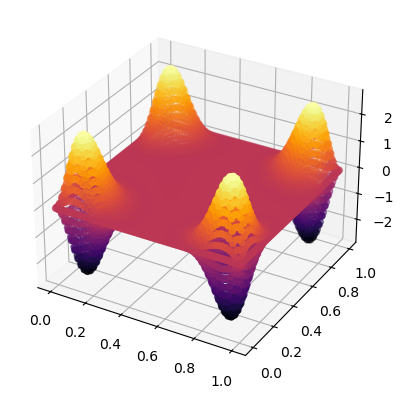

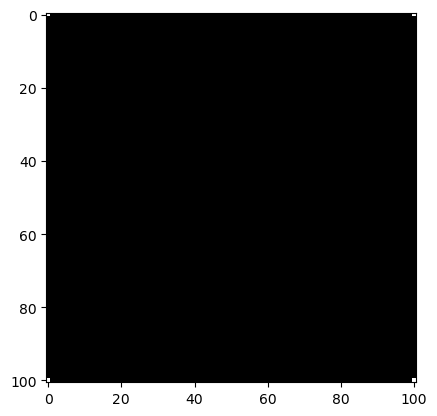

In [13]:
get_surface_gif(explicit_k1, 'explicit_1pov_t3.gif')
get_cmap_gif(explicit_k1, 'explicit_1cm_t3.gif')

### Неявнй

In [14]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

implicit_k1 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

Ура! Уже  10  итераций!
Ура! Уже  20  итераций!
Ура! Уже  30  итераций!
Ура! Уже  40  итераций!
Ура! Уже  50  итераций!
Ура! Уже  60  итераций!
Ура! Уже  70  итераций!
Ура! Уже  80  итераций!
Ура! Уже  90  итераций!
Ура! Уже  100  итераций!
Ура! Уже  110  итераций!
Ура! Уже  120  итераций!
Ура! Уже  130  итераций!
Ура! Уже  140  итераций!
Ура! Уже  150  итераций!
Ура! Уже  160  итераций!
Ура! Уже  170  итераций!
Ура! Уже  180  итераций!
Ура! Уже  190  итераций!
Ура! Уже  200  итераций!
Ура! Уже  210  итераций!
Ура! Уже  220  итераций!
Ура! Уже  230  итераций!
Ура! Уже  240  итераций!
Ура! Уже  250  итераций!
Ура! Уже  260  итераций!
Ура! Уже  270  итераций!
Ура! Уже  280  итераций!
Ура! Уже  290  итераций!
Ура! Уже  300  итераций!


201
201


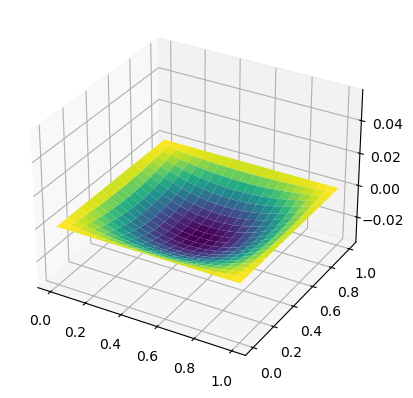

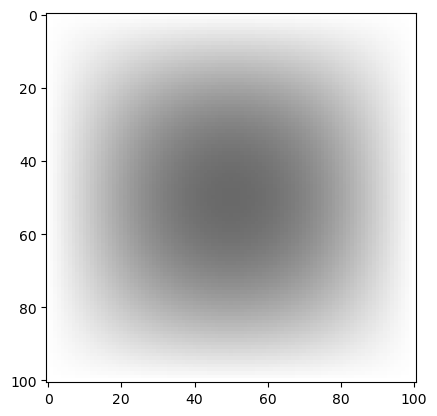

In [14]:
get_surface_gif(implicit_k1, 'implicit_1pov_t3.gif')
get_cmap_gif(implicit_k1, 'implicit_1cm_t3.gif')

### Сравнение

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in square
  sum_sq += arr[..., i, np.newaxis] ** 2
C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in add
  sum_sq += arr[..., i, np.newaxis] ** 2


NameError: name 'FFWriter' is not defined

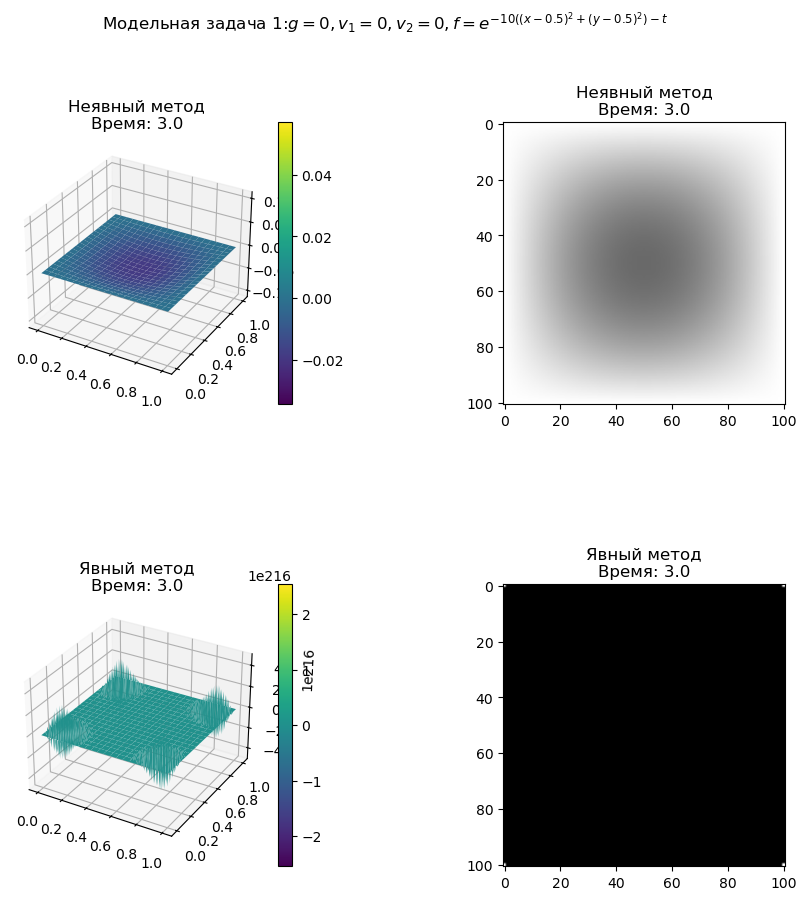

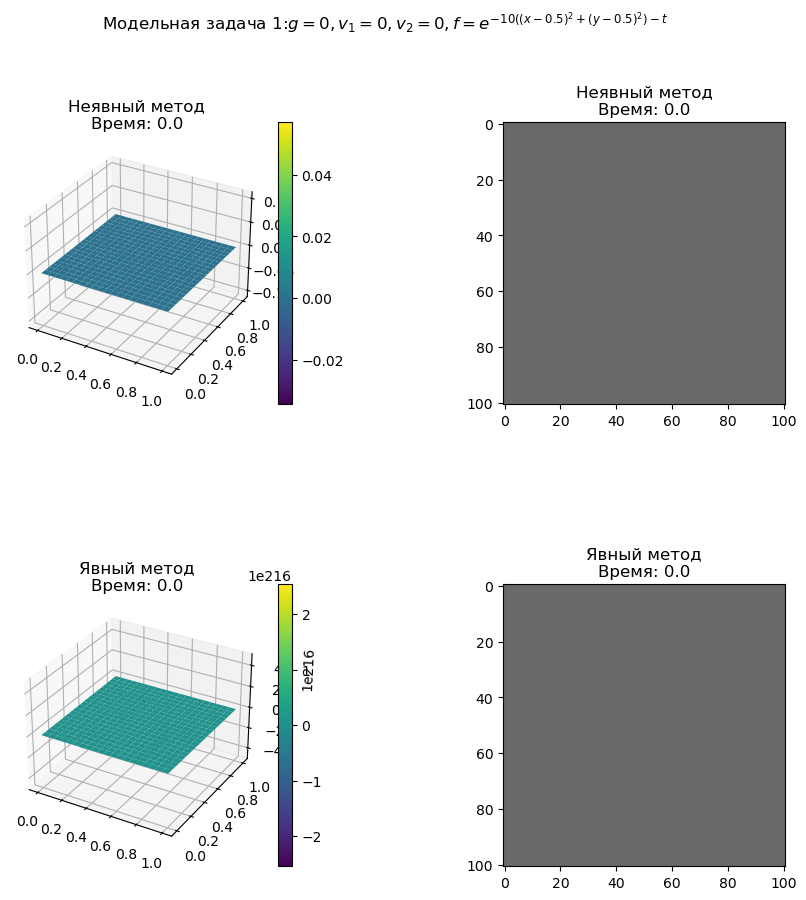

In [18]:
comparation_gifv2(x_,y_,t_,implicit_k1,explicit_k1,r'Модельная задача 1:$ g = 0,v_1 = 0,v_2 = 0,f = e^{-10((x-0.5)^2 + (y-0.5)^2)-t}$', 'model1_.html')


C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in square
  sum_sq += arr[..., i, np.newaxis] ** 2
C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in add
  sum_sq += arr[..., i, np.newaxis] ** 2


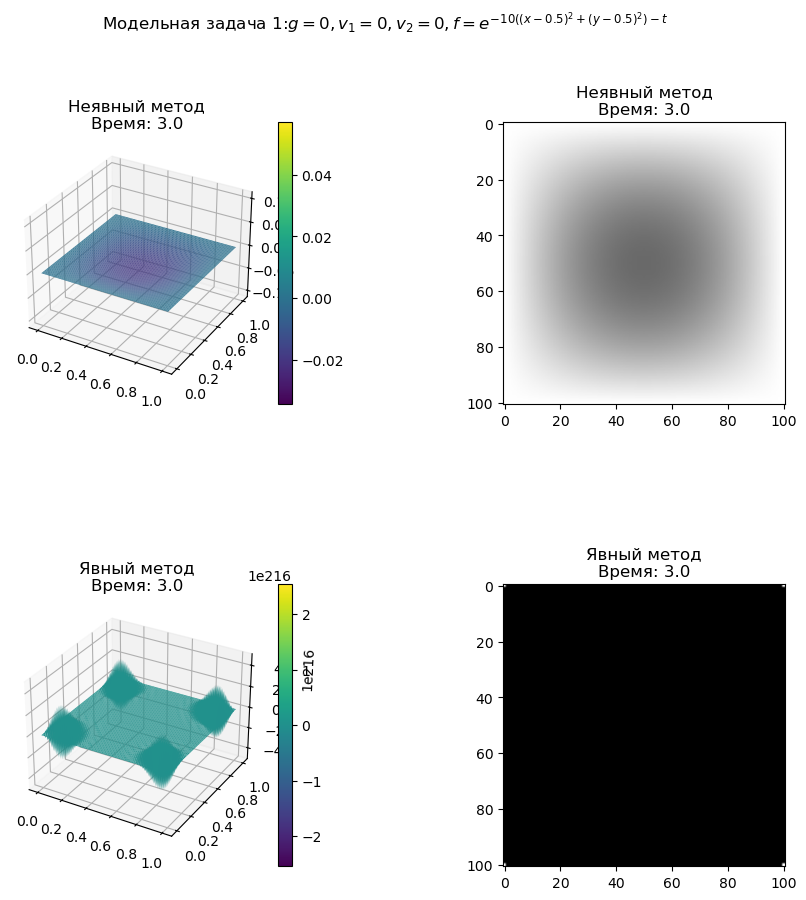

In [14]:
comparation_mp4(x_,y_,t_,implicit_k1,explicit_k1,r'Модельная задача 1:$ g = 0,v_1 = 0,v_2 = 0,f = e^{-10((x-0.5)^2 + (y-0.5)^2)-t}$', 'mod1_upd.mp4',rstride = 1, cstride=1)

## 5.2. Фикс края, забавное начальное положение, покой

$\begin{array}& g = 0, & v_1 = x^{10}(1-x)y(1-y), & v_2 = 0, & f = 0\end{array}$

In [26]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: x**10*(1-x)*(1-y)*y
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

### Явнй

In [27]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k2 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

201
201


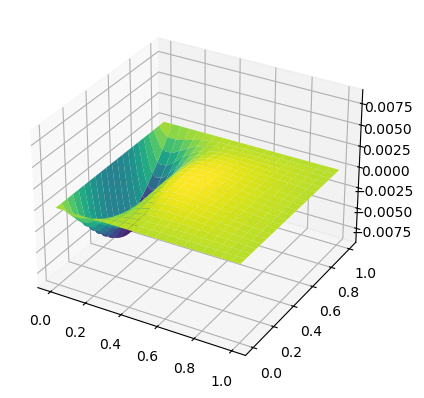

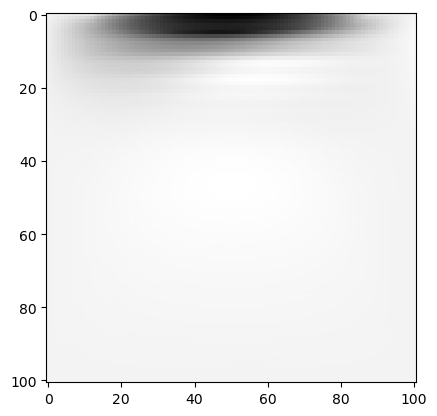

In [51]:
get_surface_gif(explicit_k2, 'explicit_2pov_t3.gif')
get_cmap_gif(explicit_k2, 'explicit_2cm_t3.gif')

### Неявнй

In [28]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

implicit_k2 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

Ура! Уже  10  итераций!
Ура! Уже  20  итераций!
Ура! Уже  30  итераций!
Ура! Уже  40  итераций!
Ура! Уже  50  итераций!
Ура! Уже  60  итераций!
Ура! Уже  70  итераций!
Ура! Уже  80  итераций!
Ура! Уже  90  итераций!
Ура! Уже  100  итераций!
Ура! Уже  110  итераций!
Ура! Уже  120  итераций!
Ура! Уже  130  итераций!
Ура! Уже  140  итераций!
Ура! Уже  150  итераций!
Ура! Уже  160  итераций!
Ура! Уже  170  итераций!
Ура! Уже  180  итераций!
Ура! Уже  190  итераций!
Ура! Уже  200  итераций!
Ура! Уже  210  итераций!
Ура! Уже  220  итераций!
Ура! Уже  230  итераций!
Ура! Уже  240  итераций!
Ура! Уже  250  итераций!
Ура! Уже  260  итераций!
Ура! Уже  270  итераций!
Ура! Уже  280  итераций!
Ура! Уже  290  итераций!
Ура! Уже  300  итераций!


201
201


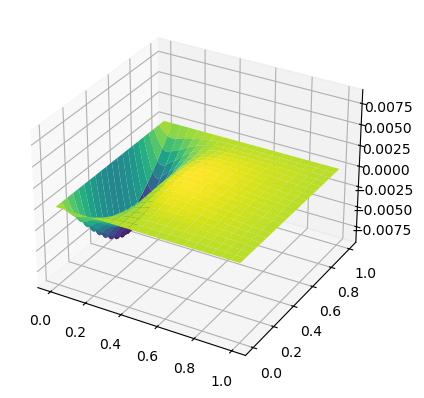

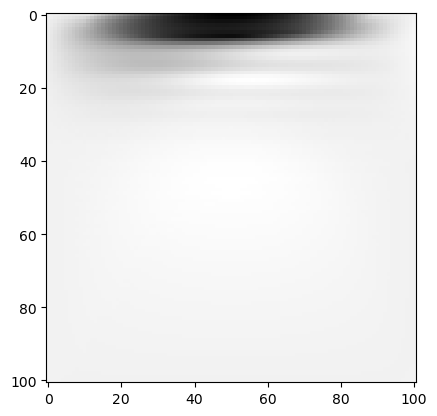

In [53]:
get_surface_gif(implicit_k2, 'implicit_2pov_t3.gif')
get_cmap_gif(implicit_k2, 'implicit_2cm_t3.gif')

### Сравнение

C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in square
  sum_sq += arr[..., i, np.newaxis] ** 2
C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in add
  sum_sq += arr[..., i, np.newaxis] ** 2


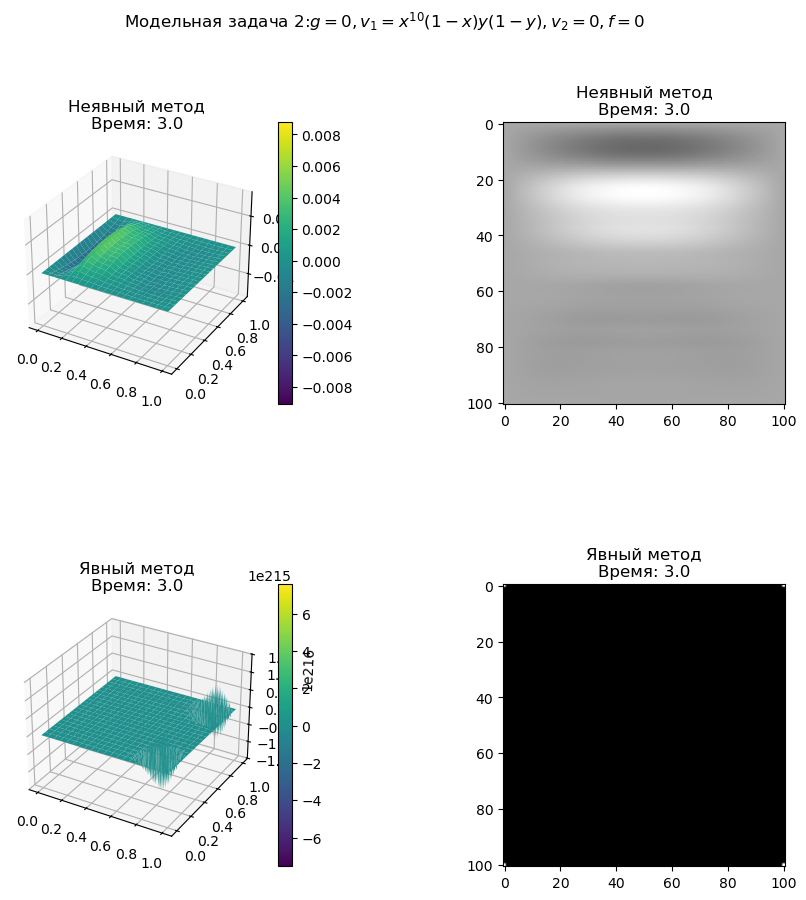

In [29]:
comparation_gifv2(x_,y_,t_,implicit_k2,explicit_k2,r'Модельная задача 2:$g = 0,v_1 = x^{10}(1-x)y(1-y),v_2 = 0,f = 0$', 'model2_.html')

## 5.3. Фикс. края, забавная скорость, покой

$\begin{array}& g = 0, & v_1 = 0, & v_2 = x^{10}(1-x)y(1-y), & f = 0\end{array}$

In [42]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: x**10*(1-x)*(1-y)*y
f = lambda x,y,t: np.zeros(x.shape)

### Явнй

In [31]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k3 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

201
201


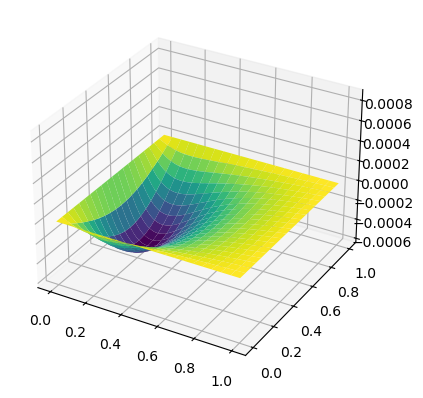

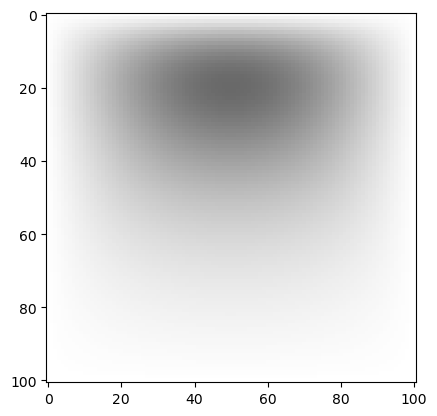

In [57]:
get_surface_gif(explicit_k3, 'explicit_3pov_t1.gif')
get_cmap_gif(explicit_k3, 'explicit_3cm_t1.gif')

### Неявнй

In [32]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

implicit_k3 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

Ура! Уже  10  итераций!
Ура! Уже  20  итераций!
Ура! Уже  30  итераций!
Ура! Уже  40  итераций!
Ура! Уже  50  итераций!
Ура! Уже  60  итераций!
Ура! Уже  70  итераций!
Ура! Уже  80  итераций!
Ура! Уже  90  итераций!
Ура! Уже  100  итераций!
Ура! Уже  110  итераций!
Ура! Уже  120  итераций!
Ура! Уже  130  итераций!
Ура! Уже  140  итераций!
Ура! Уже  150  итераций!
Ура! Уже  160  итераций!
Ура! Уже  170  итераций!
Ура! Уже  180  итераций!
Ура! Уже  190  итераций!
Ура! Уже  200  итераций!
Ура! Уже  210  итераций!
Ура! Уже  220  итераций!
Ура! Уже  230  итераций!
Ура! Уже  240  итераций!
Ура! Уже  250  итераций!
Ура! Уже  260  итераций!
Ура! Уже  270  итераций!
Ура! Уже  280  итераций!
Ура! Уже  290  итераций!
Ура! Уже  300  итераций!


201
201


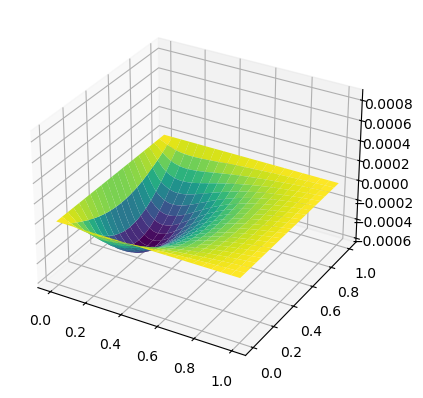

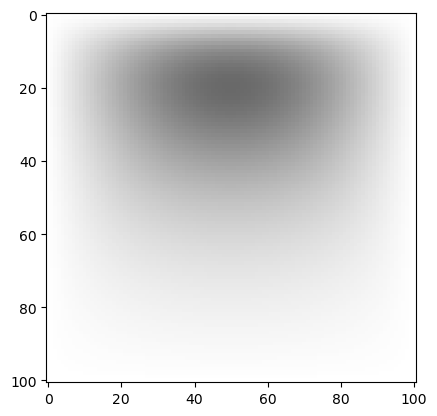

In [61]:
get_surface_gif(implicit_k3, 'implicit_3pov_t2.gif')
get_cmap_gif(implicit_k3, 'implicit_3cm_t2.gif')

### Сравнение

C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in square
  sum_sq += arr[..., i, np.newaxis] ** 2
C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in add
  sum_sq += arr[..., i, np.newaxis] ** 2


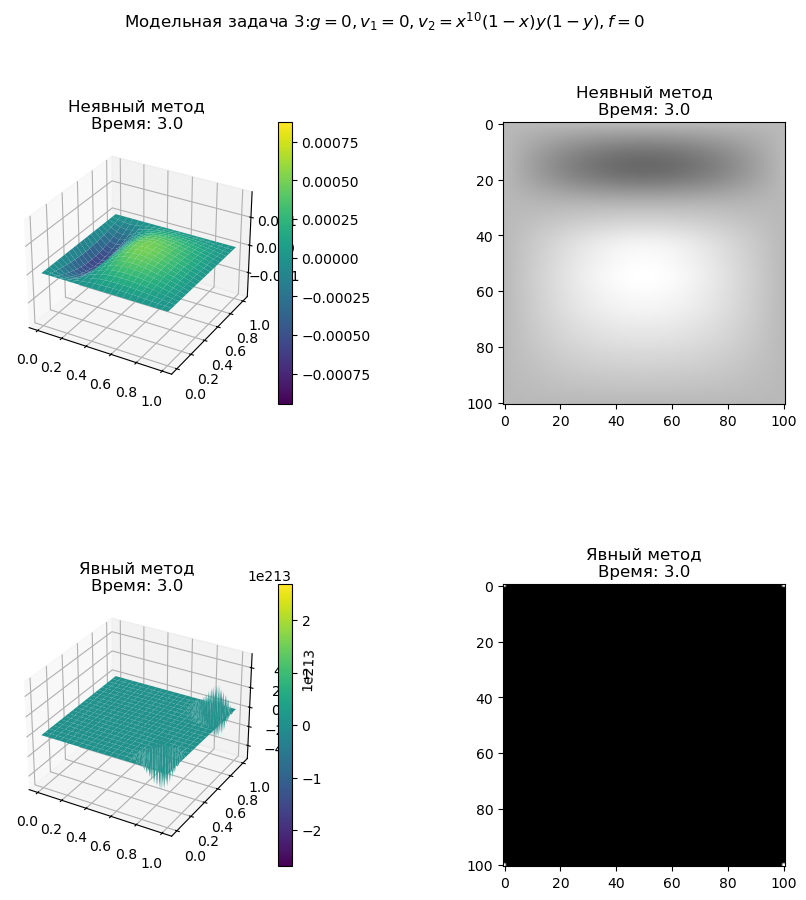

In [33]:
comparation_gifv2(x_,y_,t_,implicit_k3,explicit_k3,r'Модельная задача 3:$g = 0,v_1 = 0,v_2 = x^{10}(1-x)y(1-y),f = 0$', 'model3_.html')

## 5.4. Полиномиальнй край по $y$ и начальное положение с тригонометрией

$\begin{array}& g(0,y) = y(1-y), & g(1,y) = 0, & g(x,0) = 0, & g(x,1) = 0, & v_1= (1-x)y(1-y)\cos(5\pi x), & v_2 = 0, & f = 0 \end{array}$


In [68]:
g0 = lambda x,y,t:  y*(1-y)
g = lambda x,y,t: np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

### Явнй

In [35]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k4 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g0,g,g,g])

201
201


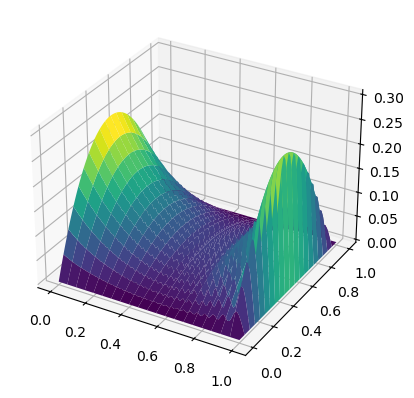

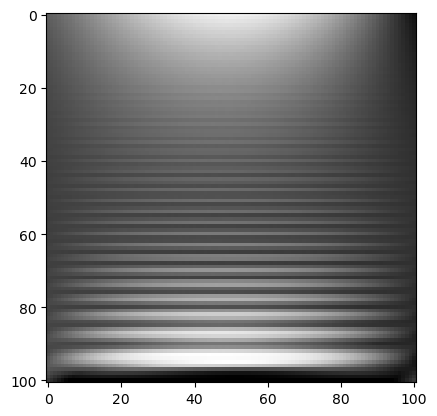

In [65]:
get_surface_gif(explicit_k4, 'explicit_4pov_t1.gif')
get_cmap_gif(explicit_k4, 'explicit_4cm_t1.gif')

### Неявнй

In [36]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

implicit_k4 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g0,g,g,g])

Ура! Уже  10  итераций!
Ура! Уже  20  итераций!
Ура! Уже  30  итераций!
Ура! Уже  40  итераций!
Ура! Уже  50  итераций!
Ура! Уже  60  итераций!
Ура! Уже  70  итераций!
Ура! Уже  80  итераций!
Ура! Уже  90  итераций!
Ура! Уже  100  итераций!
Ура! Уже  110  итераций!
Ура! Уже  120  итераций!
Ура! Уже  130  итераций!
Ура! Уже  140  итераций!
Ура! Уже  150  итераций!
Ура! Уже  160  итераций!
Ура! Уже  170  итераций!
Ура! Уже  180  итераций!
Ура! Уже  190  итераций!
Ура! Уже  200  итераций!
Ура! Уже  210  итераций!
Ура! Уже  220  итераций!
Ура! Уже  230  итераций!
Ура! Уже  240  итераций!
Ура! Уже  250  итераций!
Ура! Уже  260  итераций!
Ура! Уже  270  итераций!
Ура! Уже  280  итераций!
Ура! Уже  290  итераций!
Ура! Уже  300  итераций!


201
201


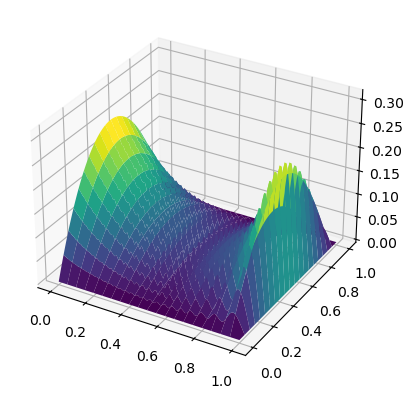

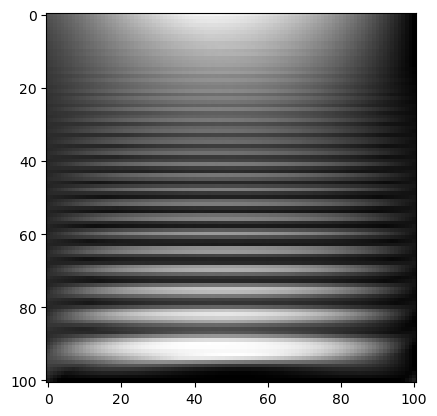

In [67]:
get_surface_gif(implicit_k4, 'implicit_4pov_t2.gif')
get_cmap_gif(implicit_k4, 'implicit_4cm_t2.gif')

### Сравнение

C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in square
  sum_sq += arr[..., i, np.newaxis] ** 2
C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in add
  sum_sq += arr[..., i, np.newaxis] ** 2


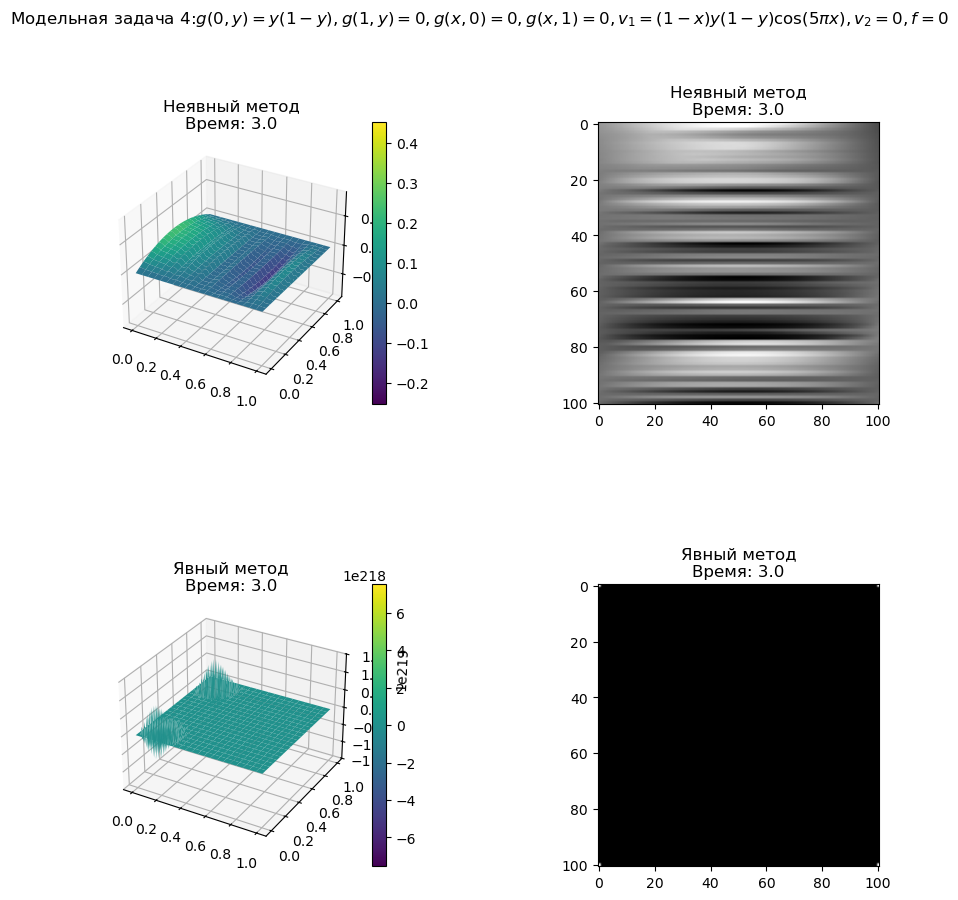

In [37]:
comparation_gifv2(x_,y_,t_,implicit_k4,explicit_k4,r'Модельная задача 4:$g(0,y) = y(1-y),g(1,y) = 0,g(x,0) = 0,g(x,1) = 0,v_1= (1-x)y(1-y)\cos(5\pi x),v_2 = 0,f = 0$', 'model4_.html')

## 5.5. Колебающиеся края

$\begin{array}& g = \dfrac{5\sin{t}}{t+1}, & v_1 = 0, &  v_2 = 0, & f = 0 \end{array}$

In [38]:
g = lambda x,y,t:  5*np.sin(5*t)/(t+1)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

### Явнй

In [39]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k5 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

201
201


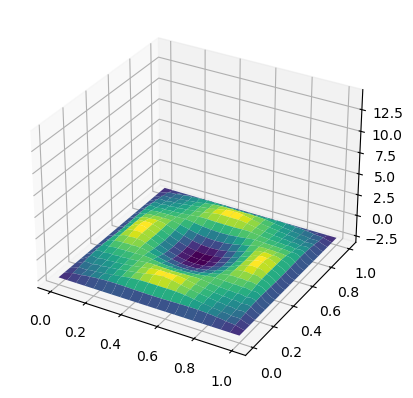

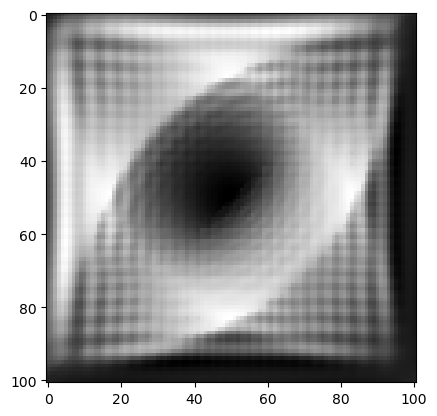

In [71]:
get_surface_gif(explicit_k5, 'explicit_5pov_t1_.gif')
get_cmap_gif(explicit_k5, 'explicit_5cm_t1_.gif')

### Неявнй

In [40]:
x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

implicit_k5 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

Ура! Уже  10  итераций!
Ура! Уже  20  итераций!
Ура! Уже  30  итераций!
Ура! Уже  40  итераций!
Ура! Уже  50  итераций!
Ура! Уже  60  итераций!
Ура! Уже  70  итераций!
Ура! Уже  80  итераций!
Ура! Уже  90  итераций!
Ура! Уже  100  итераций!
Ура! Уже  110  итераций!
Ура! Уже  120  итераций!
Ура! Уже  130  итераций!
Ура! Уже  140  итераций!
Ура! Уже  150  итераций!
Ура! Уже  160  итераций!
Ура! Уже  170  итераций!
Ура! Уже  180  итераций!
Ура! Уже  190  итераций!
Ура! Уже  200  итераций!
Ура! Уже  210  итераций!
Ура! Уже  220  итераций!
Ура! Уже  230  итераций!
Ура! Уже  240  итераций!
Ура! Уже  250  итераций!
Ура! Уже  260  итераций!
Ура! Уже  270  итераций!
Ура! Уже  280  итераций!
Ура! Уже  290  итераций!
Ура! Уже  300  итераций!


201
201


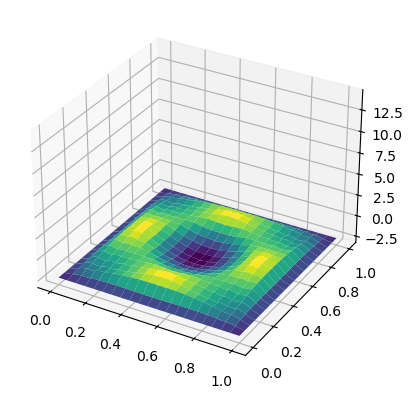

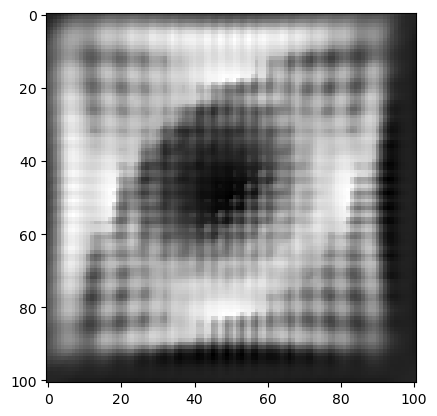

In [73]:
get_surface_gif(implicit_k5, 'implicit_5pov_t2.gif')
get_cmap_gif(implicit_k5, 'implicit_5cm_t2.gif')

### Сравнение

C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in square
  sum_sq += arr[..., i, np.newaxis] ** 2
C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in add
  sum_sq += arr[..., i, np.newaxis] ** 2


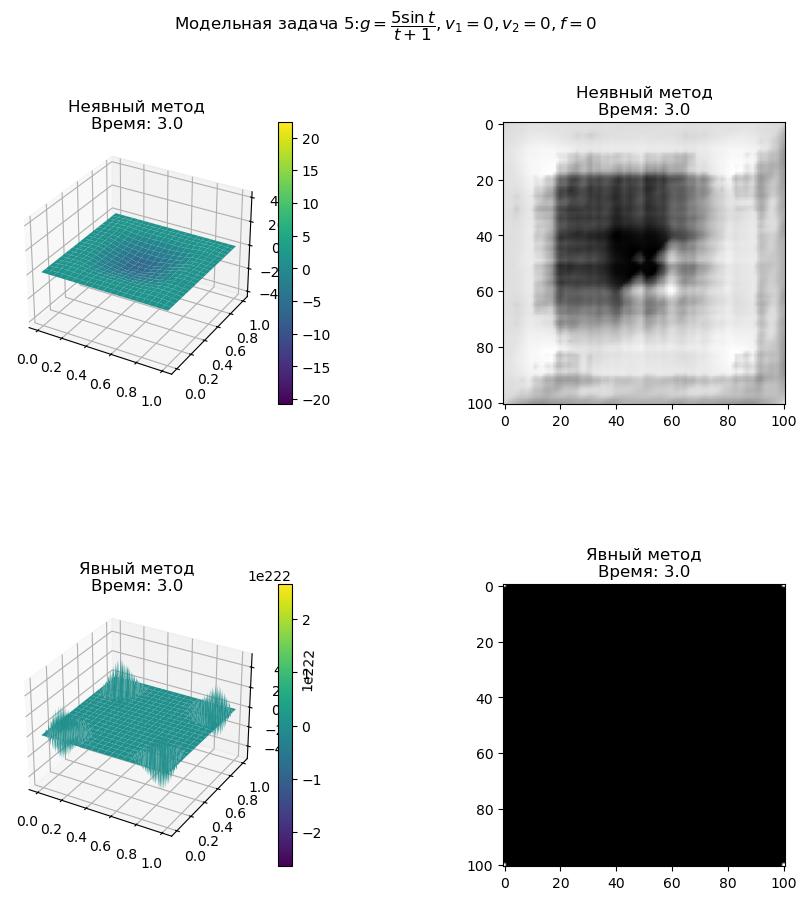

In [41]:
comparation_gifv2(x_,y_,t_,implicit_k5,explicit_k5,r'Модельная задача 5:$g = \dfrac{5\sin{t}}{t+1},v_1 = 0,v_2 = 0,f = 0$', 'model5_.html')

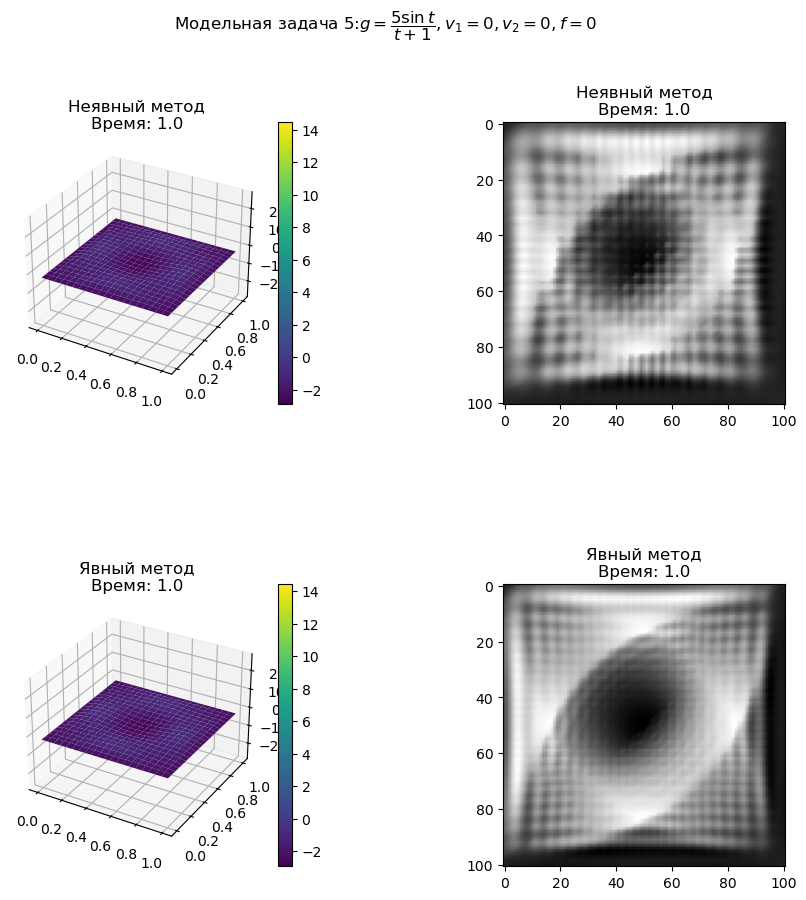

In [76]:
comparation_gifv2(x_,y_,t_,implicit_k5,explicit_k5,r'Модельная задача 5:$g = \dfrac{5\sin{t}}{t+1},v_1 = 0,v_2 = 0,f = 0$', 'model5_1.html',rstride=1,cstride=1)

## Поптка повшения размерности

Напишем ноенькие процедур, чтоб не хранить все слои сразу

In [78]:
def get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord):
    return np.meshgrid( np.linspace(t_bord[0],t_bord[1],t_cnt),np.linspace(x_bord[0],x_bord[1],x_cnt), np.linspace(y_bord[0],y_bord[1],y_cnt), indexing = 'ij')

def get_tenzor(x_cnt,y_cnt,t_cnt):
    return np.zeros((t_cnt,x_cnt,y_cnt))

explicit_right_part = lambda tenz,t,h_x,h_y,h_t,f:(tenz[t,2:,1:-1] - 2*tenz[t,1:-1,1:-1] + tenz[t,:-2,1:-1:])/h_x**2 + (tenz[t,1:-1,2:] - 2*tenz[t,1:-1,1:-1] + tenz[t,1:-1,:-2])/h_y**2 + f
implicit_right_part = lambda tenz,t,h_x,h_y,h_t,f:(tenz[t+1,2:,1:-1] - 2*tenz[t+1,1:-1,1:-1] + tenz[t+1,:-2,1:-1])/2/h_x**2 + (tenz[t-1,2:,1:-1] - 2*tenz[t-1,1:-1,1:-1] + tenz[t-1,:-2,1:-1])/2/h_x**2 + (tenz[t+1,1:-1,2:] - 2*tenz[t+1,1:-1,1:-1] + tenz[t+1,1:-1,:-2])/2/h_y**2 + (tenz[t-1,1:-1,2:] - 2*tenz[t-1,1:-1,1:-1] + tenz[t-1,1:-1,:-2])/2/h_y**2 + f
transition_to_next_layer = lambda tenz,t,h_x,h_y,h_t,f: explicit_right_part(tenz,t,h_x,h_y,h_t,f)*h_t**2+2*tenz[t,1:-1,1:-1] - tenz[t-1,1:-1,1:-1]
calc_h = lambda cnt, bord: (bord[1]-bord[0])/(cnt-1)
implicit_b_part = lambda tenz,t,h_x,h_y,h_t,f: h_t**2*((tenz[t-1,2:,1:-1] - 2*tenz[t-1,1:-1,1:-1] + tenz[t-1,:-2, 1:-1])/(2*h_x**2) + (tenz[t-1,1:-1,2:] - 2*tenz[t-1,1:-1,1:-1] + tenz[t-1,1:-1,:-2])/(2*h_y**2) + f) + 2*tenz[t,1:-1:,1:-1] - tenz[t-1,1:-1:,1:-1]

def get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,g):
    tenz = get_tenzor(x_cnt,y_cnt,t_cnt)
    t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)
    h_x = calc_h(x_cnt,x_bord)
    h_y = calc_h(y_cnt,y_bord)
    h_t = calc_h(t_cnt,t_bord)
    
    tenz [0,:,:] = v1(x_[0,:,:],y_[0,:,:])
    tenz[:,0,:] = g[0](x_[:,0,:],y_[:,0,:],t_[:,0,:])
    tenz[:,-1,:] = g[1](x_[:,-1,:],y_[:,-1,:],t_[:,-1,:])
    tenz[:,:,0] = g[2](x_[:,:,0],y_[:,:,0],t_[:,:,0])
    tenz[:,:,-1] = g[3](x_[:,:,-1],y_[:,:,-1],t_[:,:,-1])

    tenz[1,1:-1,1:-1] = v1(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1]) + h_t*v2(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1]) + (h_t**2)/2*explicit_right_part(tenz,0,h_x,h_y,h_t,f(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1],t_[0,1:-1,1:-1]))

    for i in range(2,t_cnt):
        tenz[i,1:-1,1:-1] = transition_to_next_layer(tenz,i-1,h_x,h_y,h_t,f(x_[i-1,1:-1,1:-1],y_[i-1,1:-1,1:-1],t_[i-1,1:-1,1:-1]))

    return tenz

def create_matrix_DE_v2(tenz,n,hx,hy,ht,f):
    m = tenz.shape[1] - 2
    k = tenz.shape[2] - 2
    
    N=m*k
    diagonals = [
        (1 + ht**2/hx**2 + ht**2/hy**2) * np.ones(N),      # главная диагональ (4)
        (-1)*ht**2/(2*hx**2) * np.ones(N - 1), # нижняя диагональ (-1)
        (-1)*ht**2/(2*hx**2) * np.ones(N - 1), # верхняя диагональ (-1)
        (-1)*ht**2/(2*hy**2) * np.ones(N - m), # нижняя диагональ (-m)
        (-1)*ht**2/(2*hy**2)* np.ones(N - m), # верхняя диагональ (+m)
    ]
    
    diagonals[1][m-1::m] = 0
    diagonals[2][m-1::m] = 0
#     diagonals[3][:m+1] = 0
#     diagonals[4][-m] = 0

    # Создание разреженной матрицы A
    A_ = csc_matrix(diags(diagonals, offsets=[0, -1, 1,-m,m], shape=(N, N)))
    
    
    
    
    b = implicit_b_part(tenz,n-1,hx,hy,ht,f)
#     print('b: ',(b>0).any())
    b[0,0] = b[0,0] + tenz[n,0,1] * (ht**2)/(2*hx**2) + tenz[n,1,0] * (ht**2)/(2*hy**2)
    b[0,-1] = b[0,-1] + tenz[n,0,-2] * (ht**2)/(2*hx**2) + tenz[n,1,-1] * (ht**2)/(2*hy**2)
    b[-1,0] = b[-1,0] + tenz[n,-1,1] * (ht**2)/(2*hx**2) + tenz[n,-2,0] * (ht**2)/(2*hy**2)
    b[-1,-1] = b[-1,-1] + tenz[n,-1,-2] * (ht**2)/(2*hx**2) + tenz[n,-2,-1] * (ht**2)/(2*hy**2)
    b[0,1:-1] = b[0,1:-1] + tenz[n, 0, 2:-2] *  (ht**2)/(2*hx**2)
    b[-1,1:-1] = b[-1,1:-1] + tenz[n, -1, 2:-2] *  (ht**2)/(2*hx**2)
    b[1:-1,0] = b[1:-1,0] + tenz[n,2:-2, 0] *  (ht**2)/(2*hy**2)
    b[1:-1,-1] = b[1:-1,-1] + tenz[n,2:-2, -1] *  (ht**2)/(2*hy**2)
       
    return A_,b.reshape(m*k)

def get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,g):
    tenz = get_tenzor(x_cnt,y_cnt,t_cnt)
    t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)
    h_x = calc_h(x_cnt,x_bord)
    h_y = calc_h(y_cnt,y_bord)
    h_t = calc_h(t_cnt,t_bord)
    
    tenz [0,:,:] = v1(x_[0,:,:],y_[0,:,:])
    tenz[:,0,:] = g[0](x_[:,0,:],y_[:,0,:],t_[:,0,:])
    tenz[:,-1,:] = g[1](x_[:,-1,:],y_[:,-1,:],t_[:,-1,:])
    tenz[:,:,0] = g[2](x_[:,:,0],y_[:,:,0],t_[:,:,0])
    tenz[:,:,-1] = g[3](x_[:,:,-1],y_[:,:,-1],t_[:,:,-1])

    tenz[1,1:-1,1:-1] = v1(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1]) + h_t*v2(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1]) + (h_t**2)/2*explicit_right_part(tenz,0,h_x,h_y,h_t,f(x_[0,1:-1,1:-1],y_[0,1:-1,1:-1],t_[0,1:-1,1:-1]))

    for i in range(2,t_cnt):
        A,b = create_matrix_DE(tenz,i,h_x,h_y,h_t,f(x_[i,1:-1,1:-1],y_[i,1:-1,1:-1],t_[i,1:-1,1:-1]))
    #     b_s.append(b)
    #     x, info = cg(A, b,tol=1e-12)
    
        A = csc_matrix(A)
    
        # Используем метод бисопряженных градиентов
        x, info = bicg(A, b)
        tenz[i,1:-1,1:-1] = np.copy(x.reshape((x_cnt-2,y_cnt-2)))
        if info != 0:
            print("Метод не сошелся. Код завершения:", info)
        if(i%10==0):
            print('Ура! Уже ', i, ' итераций!')

    return tenz

In [101]:
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gray
ve=0.001

def comparation_gifv3(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,g,model_name = 'None', gif_name ='default.gif', rstride=5, cstride=5,v_mx=0.4,v_mn=-0.4):
    tenz_im = get_tenzor(x_cnt,y_cnt,3)
    tenz_ex = get_tenzor(x_cnt,y_cnt,3)
    # t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)
    x_,y_ = np.meshgrid(np.linspace(x_bord[0],x_bord[1],x_cnt), np.linspace(y_bord[0],y_bord[1],y_cnt), indexing = 'ij')
    
    t_help = np.linspace(t_bord[0],t_bord[1],t_cnt)
    t_ = np.ones(x_.shape)
    h_x = calc_h(x_cnt,x_bord)
    h_y = calc_h(y_cnt,y_bord)
    h_t = calc_h(t_cnt,t_bord)

    tenz_im[0,:,:] = v1(x_[:,:],y_[:,:])
    tenz_im[0,0,:] = g[0](x_[0,:],y_[0,:],t_[0,:]*t_help[0])
    tenz_im[0,-1,:] = g[1](x_[-1,:],y_[-1,:],t_[-1,:]*t_help[0])
    tenz_im[0,:,0] = g[2](x_[:,0],y_[:,0],t_[:,0]*t_help[0])
    tenz_im[0,:,-1] = g[3](x_[:,-1],y_[:,-1],t_[:,-1]*t_help[0])

    tenz_im[1,0,:] = g[0](x_[0,:],y_[0,:],t_[0,:]*t_help[1])
    tenz_im[1,-1,:] = g[1](x_[-1,:],y_[-1,:],t_[-1,:]*t_help[1])
    tenz_im[1,:,0] = g[2](x_[:,0],y_[:,0],t_[:,0]*t_help[1])
    tenz_im[1,:,-1] = g[3](x_[:,-1],y_[:,-1],t_[:,-1]*t_help[1])

    tenz_im[2,0,:] = g[0](x_[0,:],y_[0,:],t_[0,:]*t_help[2])
    tenz_im[2,-1,:] = g[1](x_[-1,:],y_[-1,:],t_[-1,:]*t_help[2])
    tenz_im[2,:,0] = g[2](x_[:,0],y_[:,0],t_[:,0]*t_help[2])
    tenz_im[2,:,-1] = g[3](x_[:,-1],y_[:,-1],t_[:,-1]*t_help[2])
    

    tenz_im[1,1:-1,1:-1] = v1(x_[1:-1,1:-1],y_[1:-1,1:-1]) + h_t*v2(x_[1:-1,1:-1],y_[1:-1,1:-1]) + (h_t**2)/2*explicit_right_part(tenz_im,0,h_x,h_y,h_t,f(x_[1:-1,1:-1],y_[1:-1,1:-1],t_[1:-1,1:-1]*t_help[0]))

    tenz_ex[0,:,:] = v1(x_,y_)
    tenz_ex[0,0,:] = g[0](x_[0,:],y_[0,:],t_[0,:]*t_help[0])
    tenz_ex[0,-1,:] = g[1](x_[-1,:],y_[-1,:],t_[-1,:]*t_help[0])
    tenz_ex[0,:,0] = g[2](x_[:,0],y_[:,0],t_[:,0]*t_help[0])
    tenz_ex[0,:,-1] = g[3](x_[:,-1],y_[:,-1],t_[:,-1]*t_help[0])

    tenz_ex[1,0,:] = g[0](x_[0,:],y_[0,:],t_[0,:]*t_help[1])
    tenz_ex[1,-1,:] = g[1](x_[-1,:],y_[-1,:],t_[-1,:]*t_help[1])
    tenz_ex[1,:,0] = g[2](x_[:,0],y_[:,0],t_[:,0]*t_help[1])
    tenz_ex[1,:,-1] = g[3](x_[:,-1],y_[:,-1],t_[:,-1]*t_help[1])

    tenz_ex[2,0,:] = g[0](x_[0,:],y_[0,:],t_[0,:]*t_help[2])
    tenz_ex[2,-1,:] = g[1](x_[-1,:],y_[-1,:],t_[-1,:]*t_help[2])
    tenz_ex[2,:,0] = g[2](x_[:,0],y_[:,0],t_[:,0]*t_help[2])
    tenz_ex[2,:,-1] = g[3](x_[:,-1],y_[:,-1],t_[:,-1]*t_help[2])

    tenz_ex[1,1:-1,1:-1] = v1(x_[1:-1,1:-1],y_[1:-1,1:-1]) + h_t*v2(x_[1:-1,1:-1],y_[1:-1,1:-1]) + (h_t**2)/2*explicit_right_part(tenz_ex,0,h_x,h_y,h_t,f(x_[1:-1,1:-1],y_[1:-1,1:-1],t_[1:-1,1:-1]*t_help[0]))


    
    
    fig = plt.figure(figsize=(25, 25))
    fig.suptitle(model_name)
    ax1 = fig.add_subplot(221, projection='3d')
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223, projection='3d')
    ax4 = fig.add_subplot(224)

    Z_im = ls.shade(tenz_im[0],cmap=cmap, vert_exag=ve, blend_mode='hsv')
    Z_ex = ls.shade(tenz_ex[0],cmap=cmap, vert_exag=ve, blend_mode='hsv')
    
    ax1.set_zlim([2*v_mn,2*v_mx])
    ax3.set_zlim([2*v_mn,2*v_mx])
    line1 = ax1.scatter(x_, y_, tenz_im[0], cmap='inferno', tenz_im[0],vmin=v_mn, vmax = v_mx)
    line2 = ax2.imshow(Z_im, cmap=cmap)
    line3 = ax3.scatter(x_, y_, tenz_ex[0], cmap='inferno', tenz_ex[0],vmin=v_mn, vmax = v_mx)
    line4 = ax4.imshow(Z_ex, cmap=cmap)
    fig.colorbar(line1,ax=ax1,fraction =0.05,pad=0.05)
    fig.colorbar(line3,ax=ax3,fraction =0.05,pad=0.05)
    
    # Функция обновления кадров
    def update(frame):
        tenz_im[0:2,:,:] = np.copy(tenz_im[1:,:,:])
        tenz_ex[0:2,:,:] = np.copy(tenz_ex[1:,:,:])
        if frame < t_cnt -2:
    
            tenz_ex[2,1:-1,1:-1] = np.copy(transition_to_next_layer(tenz_ex,1,h_x,h_y,h_t,f(x_[1:-1,1:-1],y_[1:-1,1:-1],t_[1:-1,1:-1]*t_help[frame+1])))
    
            A,b = create_matrix_DE_v2(tenz_im,2,h_x,h_y,h_t,f(x_[1:-1,1:-1],y_[1:-1,1:-1],t_[1:-1,1:-1]*t_help[frame+2]))
    
            x, info = bicg(A, b)
            tenz_im[2,1:-1,1:-1] = np.copy(x.reshape((x_cnt-2,y_cnt-2)))

            

        for collection in ax1.collections:
            collection.remove()
        for collection in ax3.collections:
            collection.remove()
        for collection in ax2.collections:
            collection.remove()
        
        Z_im = ls.shade(tenz_im[0],cmap=cmap, vert_exag=ve, blend_mode='hsv')
        Z_ex = ls.shade(tenz_ex[0],cmap=cmap, vert_exag=ve, blend_mode='hsv')
        line2.set_array(Z_im)
        line4.set_array(Z_ex)
        line2.set_clim(Z_im.min(), Z_im.max())
        line4.set_clim(Z_ex.min(), Z_ex.max())

        line1 = ax1.scatter(x_, y_, tenz_im[0], cmap='inferno', tenz_im[0],vmin=v_mn, vmax = v_mx)
        line3 = ax3.scatter(x_, y_, tenz_ex[0], cmap='inferno', tenz_ex[0],vmin=v_mn, vmax = v_mx)
        ex
        ax2.set_title('Неявный метод'+'\nВремя: ' + str(round(t_[0,0]*t_help[frame],3)))
        ax4.set_title('Явный метод'+'\nВремя: ' + str(round(t_[0,0]*t_help[frame],3)))
        ax1.set_title('Неявный метод'+'\nВремя: ' + str(round(t_[0,0]*t_help[frame],3)))
        ax3.set_title('Явный метод'+'\nВремя: ' + str(round(t_[0,0]*t_help[frame],3)))
    
        return line1,line2,line3,line4

    plt.subplots_adjust(hspace=0.5, wspace=0.75)
    # Создаем анимацию
    ani = FuncAnimation(fig, update, frames=t_cnt, interval=150, blit=True) 
    # Сохраняем как GIF
    ani.save(gif_name,writer='html')

In [102]:
g0 = lambda x,y,t:  y*(1-y)
g = lambda x,y,t: np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

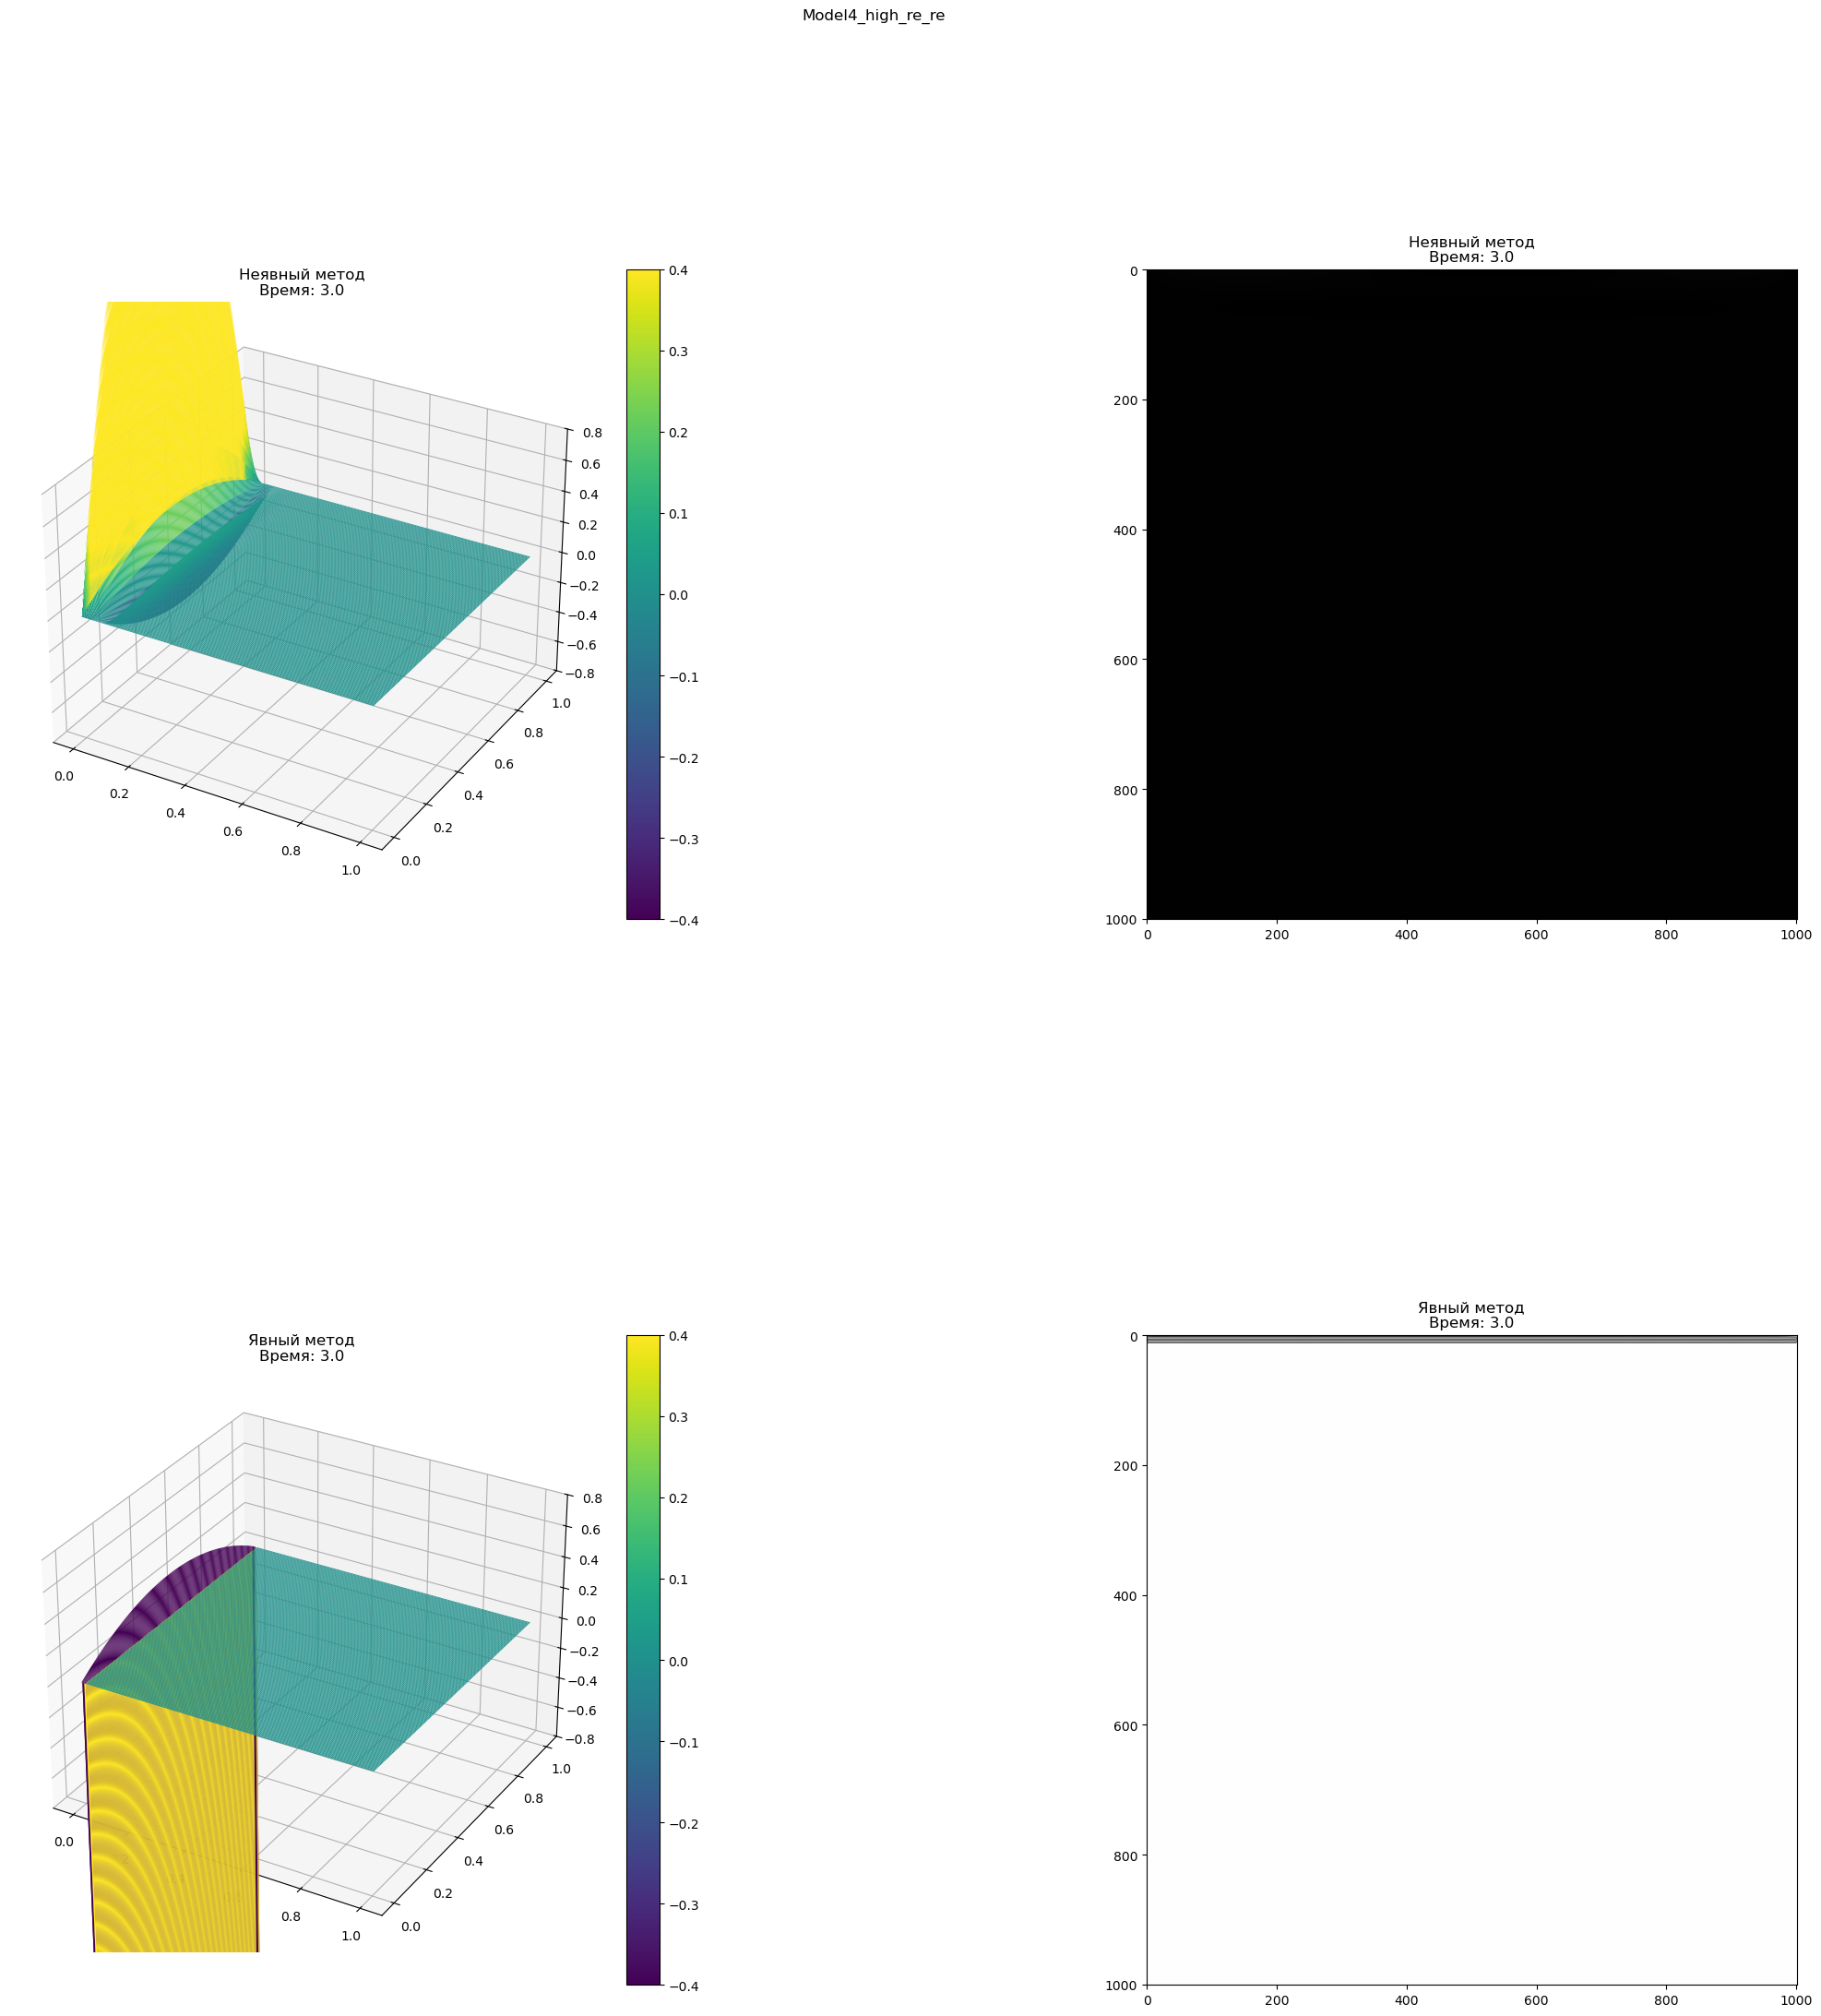

In [103]:
comparation_gifv3(1001,1001,11,[0,1],[0,1],[0,3],f,v1,v2,[g0,g,g,g],model_name = 'Model4_high_re_re', gif_name ='high_resolution_m4.html', rstride=1, cstride=1)

In [56]:
d1 = np.array((1,2,3))
d2 = np.array((1,2,4))
np.meshgrid(d1,d2)

[array([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]),
 array([[1, 1, 1],
        [2, 2, 2],
        [4, 4, 4]])]

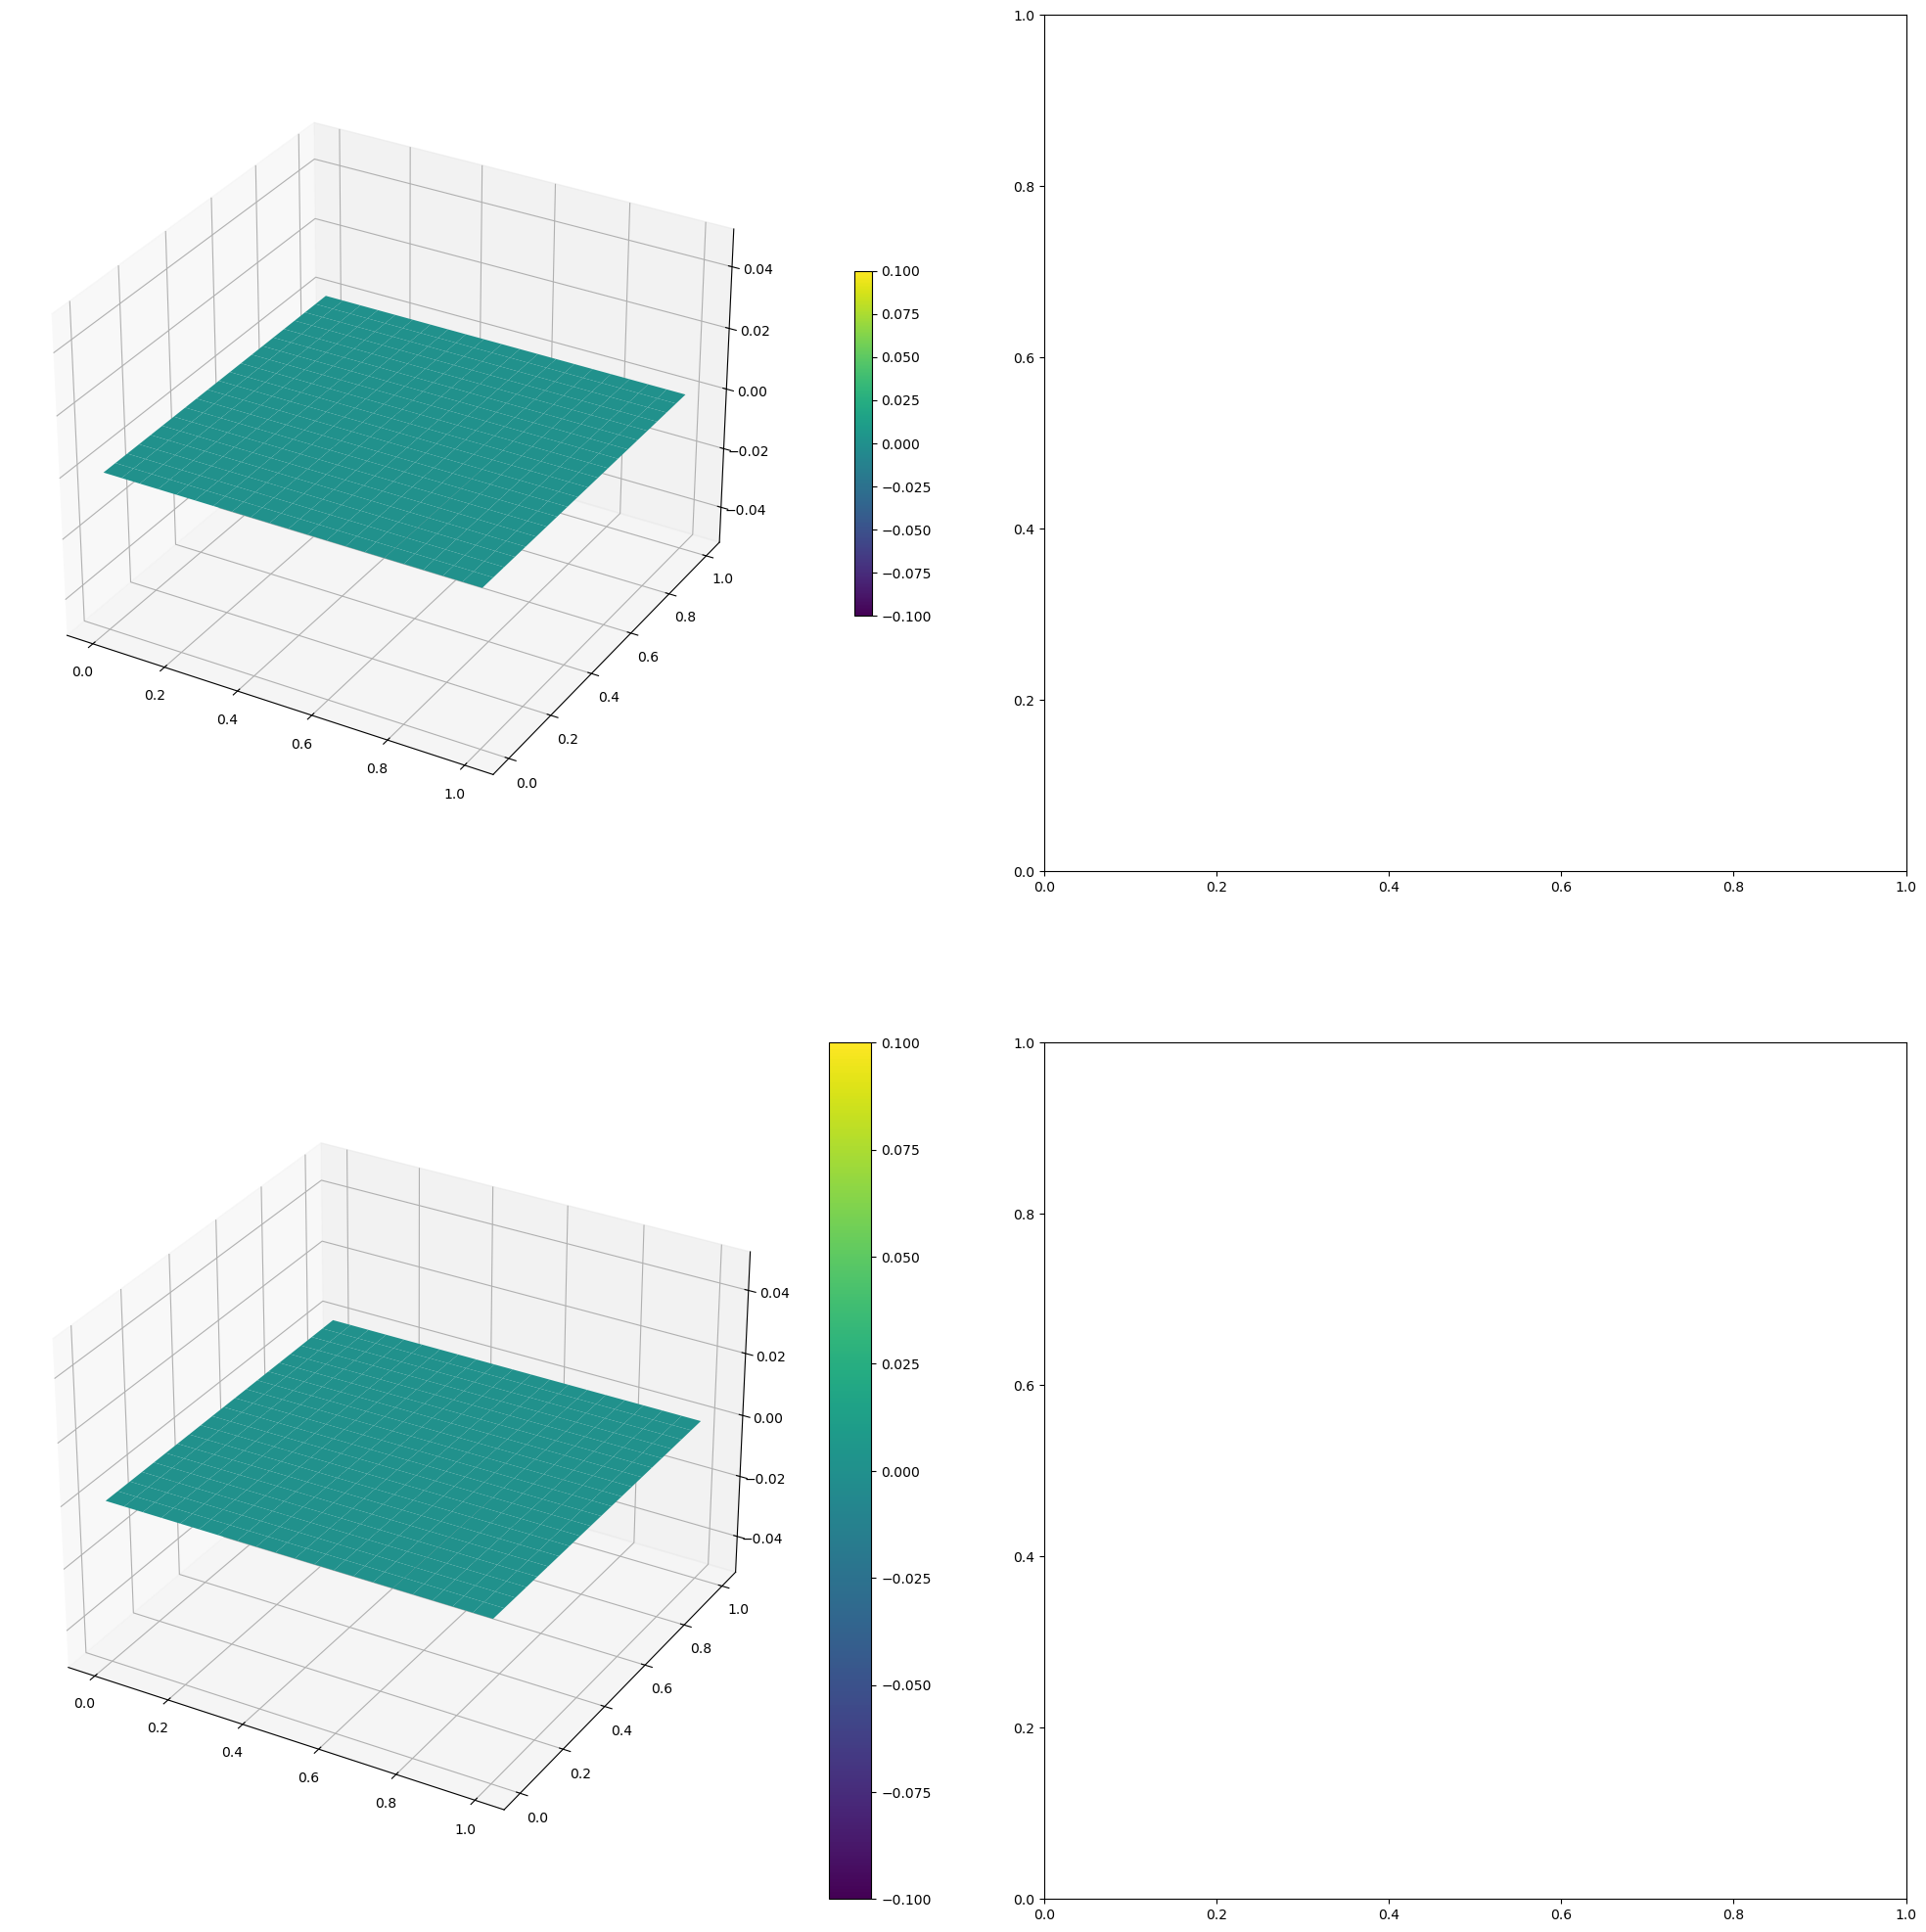

In [19]:
x_,y_ = np.meshgrid(np.linspace(x_bord[0],x_bord[1],x_cnt), np.linspace(y_bord[0],y_bord[1],y_cnt), indexing = 'ij')
fig = plt.figure(figsize=(25, 25))

ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224)


line1 = ax1.plot_surface(x_, y_, implicit_k1[0], cmap='viridis', rstride=5, cstride=5)
line3 = ax3.plot_surface(x_, y_, explicit_k1[0], cmap='viridis', rstride=5, cstride=5)
fig.colorbar(line1,ax=ax1,fraction =0.02,pad=0.1)
fig.colorbar(line3,ax=ax3,fraction =0.05,pad=0.05)

## Генерация видео

Ура! Уже  10  итераций!
Ура! Уже  20  итераций!
Ура! Уже  30  итераций!
Ура! Уже  40  итераций!
Ура! Уже  50  итераций!
Ура! Уже  60  итераций!
Ура! Уже  70  итераций!
Ура! Уже  80  итераций!
Ура! Уже  90  итераций!
Ура! Уже  100  итераций!
Ура! Уже  110  итераций!
Ура! Уже  120  итераций!
Ура! Уже  130  итераций!
Ура! Уже  140  итераций!
Ура! Уже  150  итераций!
Ура! Уже  160  итераций!
Ура! Уже  170  итераций!
Ура! Уже  180  итераций!
Ура! Уже  190  итераций!
Ура! Уже  200  итераций!
Ура! Уже  210  итераций!
Ура! Уже  220  итераций!
Ура! Уже  230  итераций!
Ура! Уже  240  итераций!
Ура! Уже  250  итераций!
Ура! Уже  260  итераций!
Ура! Уже  270  итераций!
Ура! Уже  280  итераций!
Ура! Уже  290  итераций!
Ура! Уже  300  итераций!


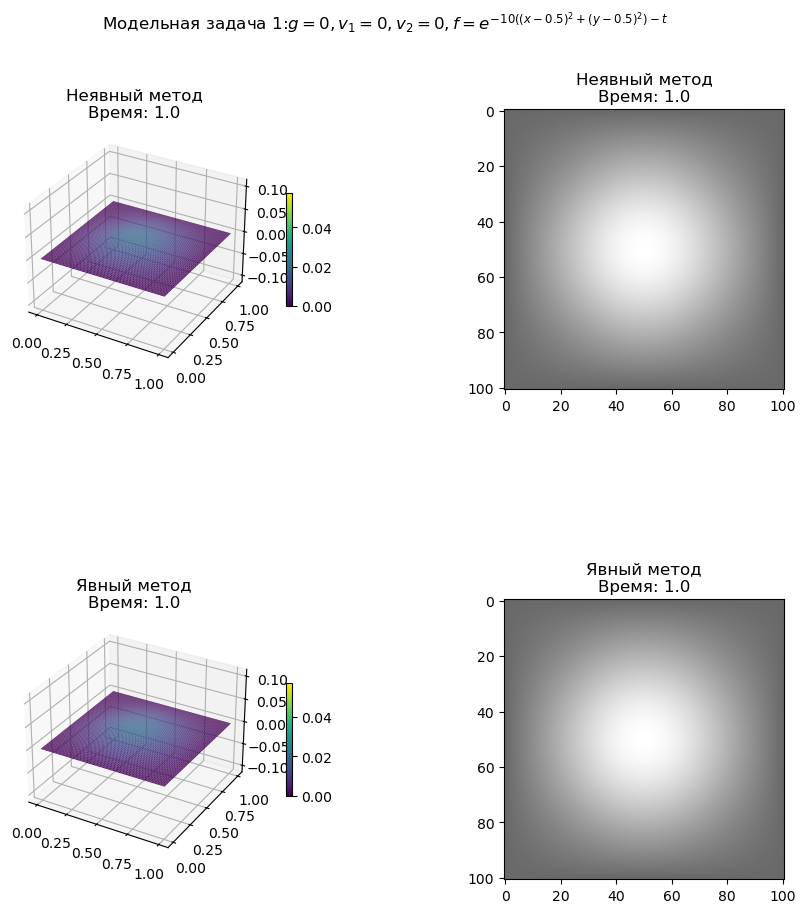

In [21]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.exp(-10*((x-0.5)**2 + (y-0.5)**2) -t)

x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,1]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k1 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])
explicit_k1 = replace_nan_and_inf(explicit_k1)
implicit_k1 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k1,explicit_k1,r'Модельная задача 1:$ g = 0,v_1 = 0,v_2 = 0,f = e^{-10((x-0.5)^2 + (y-0.5)^2)-t}$', 'mod1_try.mp4',rstride = 1, cstride=1)

Ура! Уже  10  итераций!
Ура! Уже  20  итераций!
Ура! Уже  30  итераций!
Ура! Уже  40  итераций!
Ура! Уже  50  итераций!
Ура! Уже  60  итераций!
Ура! Уже  70  итераций!
Ура! Уже  80  итераций!
Ура! Уже  90  итераций!
Ура! Уже  100  итераций!
Ура! Уже  110  итераций!
Ура! Уже  120  итераций!
Ура! Уже  130  итераций!
Ура! Уже  140  итераций!
Ура! Уже  150  итераций!
Ура! Уже  160  итераций!
Ура! Уже  170  итераций!
Ура! Уже  180  итераций!
Ура! Уже  190  итераций!
Ура! Уже  200  итераций!
Ура! Уже  210  итераций!
Ура! Уже  220  итераций!
Ура! Уже  230  итераций!
Ура! Уже  240  итераций!
Ура! Уже  250  итераций!
Ура! Уже  260  итераций!
Ура! Уже  270  итераций!
Ура! Уже  280  итераций!
Ура! Уже  290  итераций!
Ура! Уже  300  итераций!


C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in square
  sum_sq += arr[..., i, np.newaxis] ** 2
C:\Users\mihch\Anaconda3\lib\site-packages\matplotlib\colors.py:2323: RuntimeWarning: overflow encountered in add
  sum_sq += arr[..., i, np.newaxis] ** 2


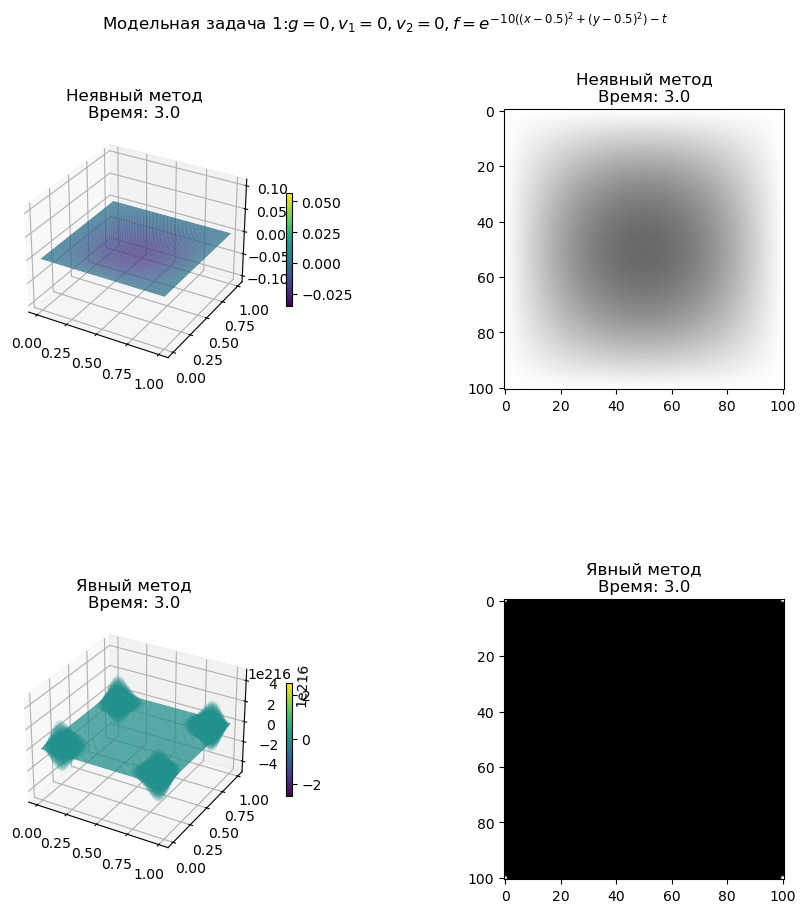

In [23]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.exp(-10*((x-0.5)**2 + (y-0.5)**2) -t)

x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k1 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])
explicit_k1 = replace_nan_and_inf(explicit_k1)
implicit_k1 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k1,explicit_k1,r'Модельная задача 1:$ g = 0,v_1 = 0,v_2 = 0,f = e^{-10((x-0.5)^2 + (y-0.5)^2)-t}$', 'mod1_try_longer.mp4',rstride = 1, cstride=1)

Ура! Уже  10  итераций!
Ура! Уже  20  итераций!
Ура! Уже  30  итераций!
Ура! Уже  40  итераций!
Ура! Уже  50  итераций!
Ура! Уже  60  итераций!
Ура! Уже  70  итераций!
Ура! Уже  80  итераций!
Ура! Уже  90  итераций!
Ура! Уже  100  итераций!
Ура! Уже  110  итераций!
Ура! Уже  120  итераций!
Ура! Уже  130  итераций!
Ура! Уже  140  итераций!
Ура! Уже  150  итераций!
Ура! Уже  160  итераций!
Ура! Уже  170  итераций!
Ура! Уже  180  итераций!
Ура! Уже  190  итераций!
Ура! Уже  200  итераций!
Ура! Уже  210  итераций!
Ура! Уже  220  итераций!
Ура! Уже  230  итераций!
Ура! Уже  240  итераций!
Ура! Уже  250  итераций!
Ура! Уже  260  итераций!
Ура! Уже  270  итераций!
Ура! Уже  280  итераций!
Ура! Уже  290  итераций!
Ура! Уже  300  итераций!


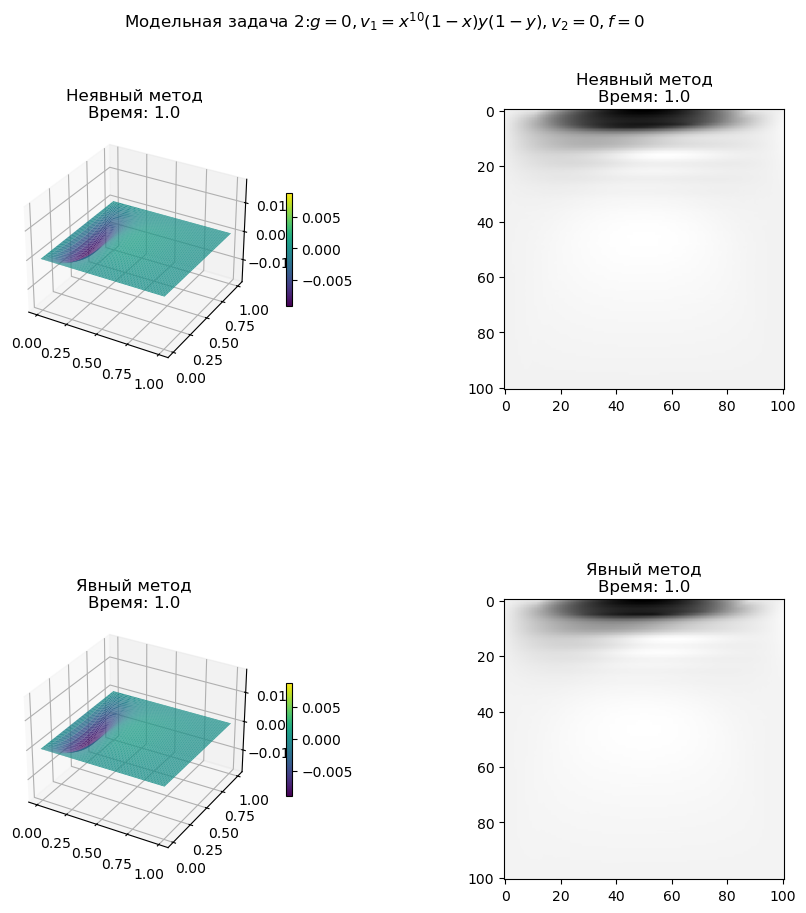

In [24]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: x**10*(1-x)*(1-y)*y
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,1]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k2 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])
implicit_k2 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k2,explicit_k2,r'Модельная задача 2:$g = 0,v_1 = x^{10}(1-x)y(1-y),v_2 = 0,f = 0$', 'mod2_try.mp4',rstride = 1, cstride=1)

Ура! Уже  10  итераций!
Ура! Уже  20  итераций!
Ура! Уже  30  итераций!
Ура! Уже  40  итераций!
Ура! Уже  50  итераций!
Ура! Уже  60  итераций!
Ура! Уже  70  итераций!
Ура! Уже  80  итераций!
Ура! Уже  90  итераций!
Ура! Уже  100  итераций!
Ура! Уже  110  итераций!
Ура! Уже  120  итераций!
Ура! Уже  130  итераций!
Ура! Уже  140  итераций!
Ура! Уже  150  итераций!
Ура! Уже  160  итераций!
Ура! Уже  170  итераций!
Ура! Уже  180  итераций!
Ура! Уже  190  итераций!
Ура! Уже  200  итераций!
Ура! Уже  210  итераций!
Ура! Уже  220  итераций!
Ура! Уже  230  итераций!
Ура! Уже  240  итераций!
Ура! Уже  250  итераций!
Ура! Уже  260  итераций!
Ура! Уже  270  итераций!
Ура! Уже  280  итераций!
Ура! Уже  290  итераций!
Ура! Уже  300  итераций!
Ура! Уже  310  итераций!
Ура! Уже  320  итераций!
Ура! Уже  330  итераций!
Ура! Уже  340  итераций!
Ура! Уже  350  итераций!
Ура! Уже  360  итераций!
Ура! Уже  370  итераций!
Ура! Уже  380  итераций!
Ура! Уже  390  итераций!
Ура! Уже  400  итераций!
Ура! Уже 

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


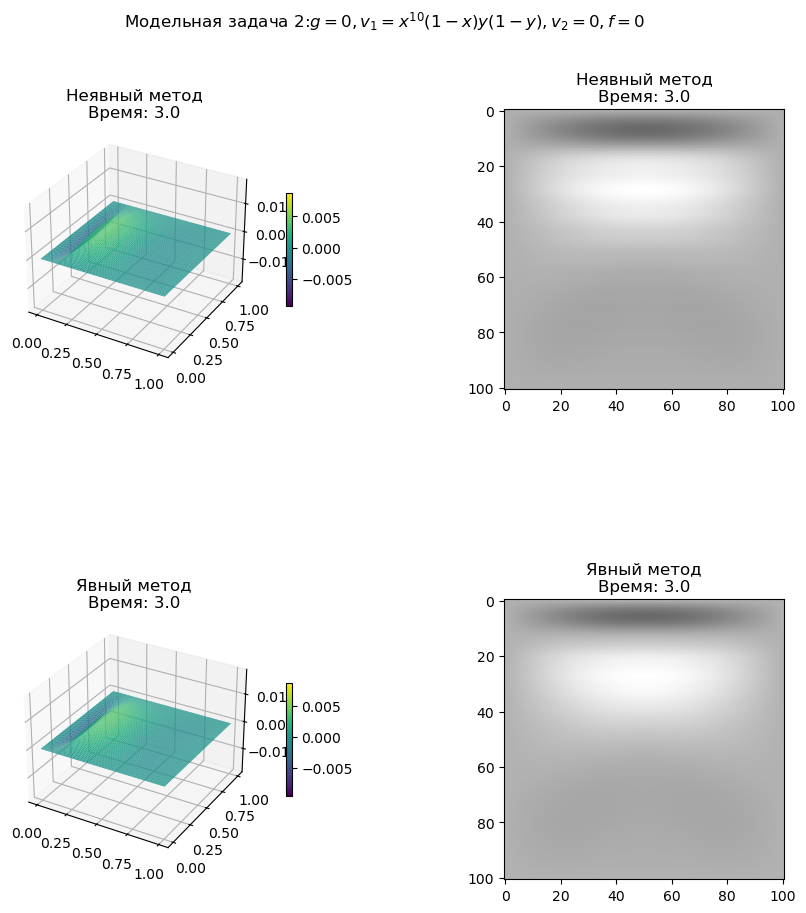

In [32]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: x**10*(1-x)*(1-y)*y
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

x_cnt = y_cnt = 101
t_cnt = 601
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k2 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])
explicit_k2 = replace_nan_and_inf(explicit_k2)
implicit_k2 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k2,explicit_k2,r'Модельная задача 2:$g = 0,v_1 = x^{10}(1-x)y(1-y),v_2 = 0,f = 0$', 'mod2_try_longer.mp4',rstride = 1, cstride=1)

In [ ]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: x**10*(1-x)*(1-y)*y
f = lambda x,y,t: np.zeros(x.shape)

x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,1]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k3 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])
implicit_k3 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k3,explicit_k3,r'Модельная задача 3:$g = 0,v_1 = 0,v_2 = x^{10}(1-x)y(1-y),f = 0$', 'mod3_try.mp4',rstride = 1, cstride=1)

In [ ]:
g = lambda x,y,t:  np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: x**10*(1-x)*(1-y)*y
f = lambda x,y,t: np.zeros(x.shape)

x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k3 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])
explicit_k3 = replace_nan_and_inf(explicit_k3)
implicit_k3 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k3,explicit_k3,r'Модельная задача 3:$g = 0,v_1 = 0,v_2 = x^{10}(1-x)y(1-y),f = 0$', 'mod3_try_longer.mp4',rstride = 1, cstride=1)

In [ ]:
g0 = lambda x,y,t:  y*(1-y)
g = lambda x,y,t: np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,1]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k4 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g0,g,g,g])
implicit_k4 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g0,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k4,explicit_k4,r'Модельная задача 4:$g(0,y) = y(1-y),g(1,y) = 0,g(x,0) = 0,g(x,1) = 0,v_1= (1-x)y(1-y)\cos(5\pi x),v_2 = 0,f = 0$', 'mod4_try.mp4',rstride = 1, cstride=1)

In [ ]:
g0 = lambda x,y,t:  y*(1-y)
g = lambda x,y,t: np.zeros(x.shape)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k4 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g0,g,g,g])
explicit_k4 = replace_nan_and_inf(explicit_k4)
implicit_k4 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g0,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k4,explicit_k4,r'Модельная задача 4:$g(0,y) = y(1-y),g(1,y) = 0,g(x,0) = 0,g(x,1) = 0,v_1= (1-x)y(1-y)\cos(5\pi x),v_2 = 0,f = 0$', 'mod4_try_longer.mp4',rstride = 1, cstride=1)

In [ ]:
g = lambda x,y,t:  5*np.sin(5*t)/(t+1)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,1]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k5 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])
implicit_k5 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k5,explicit_k5,r'Модельная задача 5:$g = \dfrac{5\sin{t}}{t+1},v_1 = 0,v_2 = 0,f = 0$', 'mod5_try.mp4',rstride = 1, cstride=1)

In [ ]:
g = lambda x,y,t:  5*np.sin(5*t)/(t+1)
v1 = lambda x,y: np.zeros(x.shape)
v2 = lambda x,y: np.zeros(x.shape)
f = lambda x,y,t: np.zeros(x.shape)

x_cnt = y_cnt = 101
t_cnt = 301
x_bord = y_bord = [0,1]; t_bord = [0,3]
t_,x_,y_ = get_mesh(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord)

explicit_k5 = get_explicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])
explicit_k5 = replace_nan_and_inf(explicit_k5)
implicit_k5 = get_implicit_solution(x_cnt,y_cnt,t_cnt,x_bord,y_bord,t_bord,f,v1,v2,[g,g,g,g])

comparation_mp4(x_,y_,t_,implicit_k5,explicit_k5,r'Модельная задача 5:$g = \dfrac{5\sin{t}}{t+1},v_1 = 0,v_2 = 0,f = 0$', 'mod5_try_longer.mp4',rstride = 1, cstride=1)